In [155]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
import lightgbm as lgbm# .loc[df_test.sku_name == new_id_test[0]]
from sklearn.preprocessing import LabelEncoder as LE
import seaborn as sns
import scipy.stats as ss
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import seaborn as sns
from matplotlib import pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [156]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
dict_s = pd.read_csv('DataDictionary.csv')

In [157]:
# test
import calendar
def count_weekends(m,y):
    day_to_count = calendar.SUNDAY

    matrix = calendar.monthcalendar(y,m)

    num_days = sum(1 for x in matrix if x[day_to_count] != 0)
    return num_days%4


In [158]:
# kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
# kf.split(y, groups=X['date'].values)
# train = train[train.sku_name.isin(test.sku_name.unique())].reset_index(drop = True)

In [159]:
test['Weeks'] = test.apply(lambda x: count_weekends(x.month, x.year), axis=1)
train['date'] = (train['year']-2016)*12 + (train['month']-1) 
test['date'] = (test['year']-2016)*12 + (test['month']-1) # train
# train['is_test'] = 0
ma = train.groupby('sku_name').apply(lambda x : x['price'].values[-1])
test['price'] = test['sku_name'].map(ma)
test['price'] = test['price'].fillna(135).astype('int')
train['price'] = train['price'].fillna(135).astype('int')
# test['is_test'] = 1

In [160]:
# all_dat = pd.concat([train,test],axis = 0).reset_index(drop = True)
# train.price.median()

In [161]:
# all_dat['price'] = all_dat.groupby('sku_name')['price'].fillna(method = 'ffill')

In [162]:
# all_dat

In [163]:

target = 'sellin'
prediction_columns = test.columns.tolist()
encoding_columns = [t for t in train.columns if t not in prediction_columns]

In [164]:
sellin = ['sellin','sellin_channel_1','sellin_channel_2','sellin_channel_3','sellin_channel_4',
         'sellin_channel_5','sellin_channel_6','sellin_channel_7','sellin_channel_8']
sellout = ['sellout','sellout_channel_1','sellout_channel_2','sellout_channel_3','sellout_channel_4',
         'sellout_channel_5','sellout_channel_6','sellout_channel_7','sellout_channel_8','sellout_channel_9',
           'sellout_channel_10']
onhand= ['onhand_inventory','onhand_inventory_channel_1','onhand_inventory_channel_2','onhand_inventory_channel_3','onhand_inventory_channel_4',
         'onhand_inventory_channel_5','onhand_inventory_channel_6','onhand_inventory_channel_7','onhand_inventory_channel_8','onhand_inventory_channel_9',
           'onhand_inventory_channel_10']

In [165]:
df_train = train.copy()
df_test = test.copy()
df_train[sellin+sellout+onhand+['leftover_inventory','starting_inventory']] = df_train[sellin+sellout+onhand+['leftover_inventory','starting_inventory']]/1013

In [166]:
# df_train.columns
pcl = df_train.groupby(['sku_name','year','month'])['product_lifecycle_stage'].apply(lambda x : x.unique()[0]).reset_index()
pcl_test = df_train.groupby('sku_name')['product_lifecycle_stage'].apply(lambda x:x.values[-1])
df_train.drop('product_lifecycle_stage',axis = 1,inplace = True)
fea1 = sellin+sellout+onhand+['leftover_inventory','starting_inventory']
fea2 = [f for f in df_train.columns.tolist() if f not in fea1]
# new_target = df_train.groupby(['sku_name','year','month'])['sellin'].sum().reset_index()
new_target = df_train.groupby(['sku_name','year','month'])[fea1].sum().reset_index()
new_target2 = df_train[fea2].groupby(['sku_name','year','month']).mean().reset_index()
df_train = new_target.merge(pcl,on = ['sku_name','year','month'],how = 'left').merge(new_target2,on = ['sku_name','year','month'],how = 'left')
df_test['product_lifecycle_stage'] = df_test['sku_name'].map(pcl_test)
price = df_train.groupby(['sku_name','year','month'])['price'].apply(lambda x : x.unique()[0]).reset_index()
price_test = df_train.groupby('sku_name')['price'].apply(lambda x:x.values[-1])
# df_test['price'] = df_test['sku_name'].map(price_test)

target = 'sellin'
prediction_columns = df_test.columns.tolist()
encoding_columns = [t for t in df_train.columns if t not in prediction_columns]
mao = df_train.groupby('sku_name').size()
df_test['size'] = df_test['sku_name'].map(mao)
df_test['size'].fillna(0,inplace = True)
df_train['size'] = df_train['sku_name'].map(mao)
df_train['sellin_old'] = df_train.groupby('sku_name')[['sellin']].shift(1).fillna(0)
df_train['sellin_old2'] = df_train.groupby('sku_name')[['sellin']].shift(2).fillna(0)
df_train['period_old'] = df_train.groupby(['sku_name'])['date'].diff().fillna(0)
df_train['period_old2'] = df_train.groupby(['sku_name'])['date'].diff(2)
ma_sell = df_train[df_train.sku_name.isin(df_test.sku_name)].groupby('sku_name').apply(lambda x : x['sellin'].values[-1])
ma_date = df_train[df_train.sku_name.isin(df_test.sku_name)].groupby('sku_name').apply(lambda x : x['date'].values[-1])

ma_sell2 = df_train.loc[(df_train.sku_name.isin(df_test.sku_name))& (df_train['size']>1)].groupby('sku_name').apply(lambda x : x['sellin'].values[-2])
ma_date2 = df_train.loc[(df_train.sku_name.isin(df_test.sku_name))& (df_train['size']>1)].groupby('sku_name').apply(lambda x : x['date'].values[-2])
df_test['sellin_old'] = df_test['sku_name'].map(ma_sell)
df_test['period_old'] = df_test['sku_name'].map(ma_date)
df_test['sellin_old2'] = df_test['sku_name'].map(ma_sell2)
df_test['period_old2'] = df_test['sku_name'].map(ma_date2)
df_test['period_old'] = df_test['date'] - df_test['period_old']
df_test['period_old2'] = df_test['date'] - df_test['period_old2']
first = df_train.groupby('sku_name').apply(lambda x :x['date'].values[0])
df_train['first_appear'] = df_train['sku_name'].map(first).astype('int')
df_test['first_appear'] = df_test['sku_name'].map(first)
df_test['first_appear'] = df_test['first_appear'].fillna(70).astype('int')

In [169]:
# df_test['date']
# df_test
# df_train.isna().sum()

In [170]:
df_train['price0'] = df_train['price']//100
df_train['price1'] = (df_train['price']//10)%10
df_train['price2'] = df_train['price']%10
df_train['price3'] = df_train['price']//10

In [171]:
add_pivotal_sum = False
add_pivotal_max = False
encode_channels = False
add_pivotal_min = False
add_kmeans = False
# enode_channels = False
add_similar_month = False

In [172]:
# df_train.groupby('sku_name').apply(lambda x: x['sellin'].sum())
# df_train[df_train.date == 45].describe()['sellin']

In [173]:
# 
# df_train[df_train.date==0].describe()['sellin'].index.tolist()
# df_train.iloc[4463]

In [174]:
# # mao.unique()[0]
# compare = pd.DataFrame(index = range(0,df_train.date.max()+1),
#                        columns = ['count','mean', 'std', 'min', '25%', '50%', '75%', 'max'])
# for i in range(0,df_train.date.max()+1):
#     compare.loc[i] = df_train[df_train.date==i].describe()['sellin']

In [175]:
# plt.plot(compare['mean'])
# plt.plot(compare['std'])
# compare
# plt.plot(compare['50%'])
# df_train = df_train[df_train.date != 45].reset_index(drop = True)
# df_train = df_train[df_train.date != 20].reset_index(drop = True)

In [176]:
if encode_channels:
        sku_name_channel_enc = df_train.groupby('sku_name')[sellin[1:]].max().idxmax(axis=1) # other encoding
        sku_name_channel_enc1 = df_train.groupby('sku_name')[sellin[1:]].min().idxmin(axis=1)# train.groupby('sku_name')[sellin[1:]].min().idxmin(axis=1) # other encoding
        df_train['sku_name_channel_enc'] = df_train['sku_name'].map(sku_name_channel_enc)
        df_train['sku_name_channel_enc1'] = df_train['sku_name'].map(sku_name_channel_enc1)
        df_test['sku_name_channel_enc'] = df_test['sku_name'].map(sku_name_channel_enc)
        df_test['sku_name_channel_enc1'] = df_test['sku_name'].map(sku_name_channel_enc1)
        df_test['sku_name_channel_enc1'].fillna('sellin_channel_1', inplace=True)
        df_test['sku_name_channel_enc'].fillna('sellin_channel_4', inplace=True)
        le = LE()
        df_train['sku_name_channel_enc1'] = le.fit_transform(df_train['sku_name_channel_enc1'])
        df_test['sku_name_channel_enc1'] = le.transform(df_test['sku_name_channel_enc1'])
        le = LE()
        df_train['sku_name_channel_enc'] = le.fit_transform(df_train['sku_name_channel_enc'])
        df_test['sku_name_channel_enc'] = le.transform(df_test['sku_name_channel_enc'])
        

In [177]:
if add_pivotal_sum:
        cols = ['month_'+str(i+1) for i in range(12) ]
        exp = df_train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
        exp.columns = ['sku_name']+ cols
        from sklearn.impute import KNNImputer
#         imputer = KNNImputer(n_neighbors=5)
#         exp[cols] = imputer.fit_transform(exp[cols])
        exp.fillna(0,inplace = True)
        exp.set_index('sku_name',inplace = True)
        for c in cols:
            df_test['sku_name_target_enc_sum_'+c] = df_test['sku_name'].map(exp[c])
            tmp = np.repeat(np.nan, df_train.shape[0])
            kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
            for idx_1, idx_2 in kf.split(df_train):
                exp2 = df_train.iloc[idx_1].groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
                exp2.columns = ['sku_name']+ cols
                imputer = KNNImputer(n_neighbors=20)
                exp2[cols] = imputer.fit_transform(exp2[cols])
                exp2.set_index('sku_name',inplace = True)

                tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(exp2[c])
                df_train['sku_name_target_enc_sum_'+c] = tmp
        imputer = KNNImputer(n_neighbors=20)
        df_train[['sku_name_target_enc_sum_'+j for j in cols]] = imputer.fit_transform(df_train[['sku_name_target_enc_sum_'+j for j in cols]])
if add_pivotal_min:
        cols = ['month_'+str(i+1) for i in range(12) ]
        exp = df_train.groupby(['sku_name','month'])[sellin[0]].min().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
        exp.columns = ['sku_name']+ cols
        from sklearn.impute import KNNImputer
#         imputer = KNNImputer(n_neighbors=5)
#         exp[cols] = imputer.fit_transform(exp[cols])
        exp.fillna(0,inplace = True)
    
        
        exp.set_index('sku_name',inplace = True)
        for c in cols:
            df_test['sku_name_target_enc_min_'+c] = df_test['sku_name'].map(exp[c])
            tmp = np.repeat(np.nan, df_train.shape[0])
            kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
            for idx_1, idx_2 in kf.split(df_train):
                exp2 = df_train.iloc[idx_1].groupby(['sku_name','month'])[sellin[0]].min().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
                exp2.columns = ['sku_name']+ cols
#                 imputer = KNNImputer(n_neighbors=5)
#                 exp2[cols] = imputer.fit_transform(exp2[cols])
                exp2.set_index('sku_name',inplace = True)

                tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(exp2[c])
                df_train['sku_name_target_enc_min_'+c] = tmp
        imputer = KNNImputer(n_neighbors=20)
        df_train[['sku_name_target_enc_min_'+j for j in cols]] = imputer.fit_transform(df_train[['sku_name_target_enc_min_'+j for j in cols]])
if add_pivotal_max:
        cols = ['month_'+str(i+1) for i in range(12) ]
        exp = df_train.groupby(['sku_name','month'])[sellin[0]].max().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
        exp.columns = ['sku_name']+ cols
        from sklearn.impute import KNNImputer
#         imputer = KNNImputer(n_neighbors=5)
#         exp[cols] = imputer.fit_transform(exp[cols])
        exp.fillna(0,inplace = True)

        exp.set_index('sku_name',inplace = True)
        for c in cols:
            df_test['sku_name_target_enc_max_'+c] = df_test['sku_name'].map(exp[c])
            tmp = np.repeat(np.nan, df_train.shape[0])
            kf = KFold(n_splits = 5, shuffle=True,random_state = 9910325)
            for idx_1, idx_2 in kf.split(df_train):
                exp2 = df_train.iloc[idx_1].groupby(['sku_name','month'])[sellin[0]].max().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').reset_index()
                exp2.columns = ['sku_name']+ cols
#                 imputer = KNNImputer(n_neighbors=5)
#                 exp2[cols] = imputer.fit_transform(exp2[cols])
                exp2.set_index('sku_name',inplace = True)

                tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(exp2[c])
                df_train['sku_name_target_enc_max_'+c] = tmp
        imputer = KNNImputer(n_neighbors=20)
        df_train[['sku_name_target_enc_max_'+j for j in cols]] = imputer.fit_transform(df_train[['sku_name_target_enc_max_'+j for j in cols]])


In [178]:
# sns.displot(
# exp[exp.isna().sum(axis = 1)==6]
#     .drop('sku_name',axis = 1).mean(axis = 1))
pivotal_sum_fea = ['sku_name_target_enc_sum_month_'+str(i+1) for i in range(12) ]
pivotal_min_fea = ['sku_name_target_enc_min_month_'+str(i+1) for i in range(12) ]
pivotal_max_fea = ['sku_name_target_enc_max_month_'+str(i+1) for i in range(12) ]
pivot_fea = pivotal_sum_fea + pivotal_max_fea + pivotal_min_fea
# new_fea = [f for f in X_train.columns if f not in pivot_fea ]
price_enc =  ['sku_namepriceenc6','sku_namepriceenc5','sku_namepriceenc4','sku_namepriceenc','sku_namepriceenc1','sku_namepriceenc2','sku_namepriceenc3']
sellin_enc =  ['sku_namesellinenc6','sku_namesellinenc5','sku_namesellinenc4','sku_namesellinenc','sku_namesellinenc1','sku_namesellinenc2','sku_namesellinenc3']
sellout_enc =  ['sku_nameselloutenc6','sku_nameselloutenc5','sku_nameselloutenc4','sku_nameselloutenc','sku_nameselloutenc1','sku_nameselloutenc2','sku_nameselloutenc3']
onhand_inventory_enc =  ['sku_nameonhand_inventoryenc6','sku_nameonhand_inventoryenc5','sku_nameonhand_inventoryenc4','sku_nameonhand_inventoryenc','sku_nameonhand_inventoryenc1','sku_nameonhand_inventoryenc2','sku_nameonhand_inventoryenc3']
starting_inventory_enc =  ['sku_namestarting_inventoryenc6','sku_namestarting_inventoryenc5','sku_namestarting_inventoryenc4','sku_namestarting_inventoryenc','sku_namestarting_inventoryenc1','sku_namestarting_inventoryenc2','sku_namestarting_inventoryenc3']
enc_features = price_enc + sellin_enc + sellout_enc + onhand_inventory_enc + starting_inventory_enc 

In [179]:
spliti = 'kfold'

In [180]:
# df_train = df_train.groupby(['sku_name','year','month']).mean().reset_index()
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = len(train_array)
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

if spliti == 'kfold':
    def target_encode(df_train,df_test,target):
        sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
        sku_name_target_max = df_train.groupby('sku_name')[target].max()
        sku_name_target_min = df_train.groupby('sku_name')[target].min()
        sku_name_target_std = df_train.groupby('sku_name')[target].std()
        sku_name_target_median = df_train.groupby('sku_name')[target].apply(lambda x : np.median(x))
        sku_name_target_q95 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95))
        sku_name_target_q05 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05))
        # sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
        df_test['sku_name'+target+'enc'] = df_test['sku_name'].map(sku_name_target_mean)
        df_test['sku_name'+target+'enc'].fillna((df_test['sku_name'+target+'enc'].mean()), inplace=True)
        df_test['sku_name'+target+'enc1'] = df_test['sku_name'].map(sku_name_target_max)
        df_test['sku_name'+target+'enc1'].fillna((df_test['sku_name'+target+'enc1'].mean()), inplace=True)
        df_test['sku_name'+target+'enc2'] = df_test['sku_name'].map(sku_name_target_min)
        df_test['sku_name'+target+'enc2'].fillna((df_test['sku_name'+target+'enc2'].mean()), inplace=True)
        df_test['sku_name'+target+'enc3'] = df_test['sku_name'].map(sku_name_target_std)
        df_test['sku_name'+target+'enc3'].fillna((df_test['sku_name'+target+'enc3'].mean()), inplace=True)
        df_test['sku_name'+target+'enc4'] = df_test['sku_name'].map(sku_name_target_median)
        df_test['sku_name'+target+'enc4'].fillna((df_test['sku_name'+target+'enc4'].mean()), inplace=True)
        df_test['sku_name'+target+'enc5'] = df_test['sku_name'].map(sku_name_target_q95)
        df_test['sku_name'+target+'enc5'].fillna((df_test['sku_name'+target+'enc5'].mean()), inplace=True)
        df_test['sku_name'+target+'enc6'] = df_test['sku_name'].map(sku_name_target_q05)
        df_test['sku_name'+target+'enc6'].fillna((df_test['sku_name'+target+'enc6'].mean()), inplace=True)
        tmp =np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc6'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc5'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.median(x))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc4'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].mean()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
        for idx_1, idx_2 in kf.split(df_train):
            target_max = df_train.iloc[idx_1].groupby('sku_name')[target].max()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_max)
        df_train['sku_name'+target+'enc1'] = tmp
        # from sklearn.model_selection import KFold/
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
        for idx_1, idx_2 in kf.split(df_train):
            target_min = df_train.iloc[idx_1].groupby('sku_name')[target].min()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_min)
        df_train['sku_name'+target+'enc2'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_std = df_train.iloc[idx_1].groupby('sku_name')[target].std()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_std)
        df_train['sku_name'+target+'enc3'] = tmp
        df_train['sku_name'+target+'enc'].fillna((df_train['sku_name'+target+'enc'].mean()), inplace=True)
        df_train['sku_name'+target+'enc1'].fillna((df_train['sku_name'+target+'enc1'].mean()), inplace=True)
        df_train['sku_name'+target+'enc2'].fillna((df_train['sku_name'+target+'enc2'].mean()), inplace=True)
        df_train['sku_name'+target+'enc3'].fillna((df_train['sku_name'+target+'enc3'].mean()), inplace=True)
        df_train['sku_name'+target+'enc4'].fillna((df_train['sku_name'+target+'enc4'].mean()), inplace=True)
        df_train['sku_name'+target+'enc5'].fillna((df_train['sku_name'+target+'enc5'].mean()), inplace=True)
        df_train['sku_name'+target+'enc6'].fillna((df_train['sku_name'+target+'enc6'].mean()), inplace=True)
        return df_train, df_test
    # train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmax(axis = 1) # other encoding
    # train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmin(axis = 1).reset_index() # other encoding

    def target_encode_p(df_train,df_test,target):
        sku_name_target_mean = df_train.groupby('sku_name')[target].mean().round().astype('int16')
        sku_name_target_max = df_train.groupby('sku_name')[target].max().round().astype('int16')
        sku_name_target_min = df_train.groupby('sku_name')[target].min().round().astype('int16')
        sku_name_target_std = df_train.groupby('sku_name')[target].std()
        sku_name_target_median = df_train.groupby('sku_name')[target].apply(lambda x : np.median(x).round().astype('int16'))
        sku_name_target_q95 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95).round().astype('int16'))
        sku_name_target_q05 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05).round().astype('int16'))
        # sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
        df_test['sku_name'+target+'enc'] = df_test['sku_name'].map(sku_name_target_mean)
        df_test['sku_name'+target+'enc'].fillna((df_test['sku_name'+target+'enc'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc1'] = df_test['sku_name'].map(sku_name_target_max)
        df_test['sku_name'+target+'enc1'].fillna((df_test['sku_name'+target+'enc1'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc2'] = df_test['sku_name'].map(sku_name_target_min)
        df_test['sku_name'+target+'enc2'].fillna((df_test['sku_name'+target+'enc2'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc3'] = df_test['sku_name'].map(sku_name_target_std)
        df_test['sku_name'+target+'enc3'].fillna((df_test['sku_name'+target+'enc3']), inplace=True)
        df_test['sku_name'+target+'enc4'] = df_test['sku_name'].map(sku_name_target_median)
        df_test['sku_name'+target+'enc4'].fillna((df_test['sku_name'+target+'enc4'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc5'] = df_test['sku_name'].map(sku_name_target_q95)
        df_test['sku_name'+target+'enc5'].fillna((df_test['sku_name'+target+'enc5'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc6'] = df_test['sku_name'].map(sku_name_target_q05)
        df_test['sku_name'+target+'enc6'].fillna((df_test['sku_name'+target+'enc6'].mean().round().astype('int16')), inplace=True)
        tmp =np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05).round().astype('int16'))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc6'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95).round().astype('int16'))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc5'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.median(x).round().astype('int16'))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc4'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].mean().round().astype('int16')

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
        for idx_1, idx_2 in kf.split(df_train):
            target_max = df_train.iloc[idx_1].groupby('sku_name')[target].max().round().astype('int16')

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_max)
        df_train['sku_name'+target+'enc1'] = tmp
        # from sklearn.model_selection import KFold/
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
        for idx_1, idx_2 in kf.split(df_train):
            target_min = df_train.iloc[idx_1].groupby('sku_name')[target].min().round().astype('int16')

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_min)
        df_train['sku_name'+target+'enc2'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_std = df_train.iloc[idx_1].groupby('sku_name')[target].std()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_std)
        df_train['sku_name'+target+'enc3'] = tmp
        df_train['sku_name'+target+'enc'].fillna((df_train['sku_name'+target+'enc'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc1'].fillna((df_train['sku_name'+target+'enc1'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc2'].fillna((df_train['sku_name'+target+'enc2'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc3'].fillna((df_train['sku_name'+target+'enc3'].mean()), inplace=True)
        df_train['sku_name'+target+'enc4'].fillna((df_train['sku_name'+target+'enc4'].mean().round().astype('int16').round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc5'].fillna((df_train['sku_name'+target+'enc5'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc6'].fillna((df_train['sku_name'+target+'enc6'].mean().round().astype('int16')), inplace=True)
        return df_train, df_test
    # train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmax(axis = 1) # other encoding
# train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmin(axis = 1).reset_index() # other encoding
    
if spliti == 'purged':
    def target_encode_p(df_train,df_test,target):
        kfolds = 5
        sku_name_target_mean = df_train.groupby('sku_name')[target].mean().round().astype('int16')
        sku_name_target_max = df_train.groupby('sku_name')[target].max().round().astype('int16')
        sku_name_target_min = df_train.groupby('sku_name')[target].min().round().astype('int16')
        sku_name_target_std = df_train.groupby('sku_name')[target].std()
        sku_name_target_median = df_train.groupby('sku_name')[target].apply(lambda x : np.median(x).round().astype('int16'))
        sku_name_target_q95 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95).round().astype('int16'))
        sku_name_target_q05 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05).round().astype('int16'))
        # sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
        df_test['sku_name'+target+'enc'] = df_test['sku_name'].map(sku_name_target_mean)
        df_test['sku_name'+target+'enc'].fillna((df_test['sku_name'+target+'enc'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc1'] = df_test['sku_name'].map(sku_name_target_max)
        df_test['sku_name'+target+'enc1'].fillna((df_test['sku_name'+target+'enc1'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc2'] = df_test['sku_name'].map(sku_name_target_min)
        df_test['sku_name'+target+'enc2'].fillna((df_test['sku_name'+target+'enc2'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc3'] = df_test['sku_name'].map(sku_name_target_std)
        df_test['sku_name'+target+'enc3'].fillna((df_test['sku_name'+target+'enc3']), inplace=True)
        df_test['sku_name'+target+'enc4'] = df_test['sku_name'].map(sku_name_target_median)
        df_test['sku_name'+target+'enc4'].fillna((df_test['sku_name'+target+'enc4'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc5'] = df_test['sku_name'].map(sku_name_target_q95)
        df_test['sku_name'+target+'enc5'].fillna((df_test['sku_name'+target+'enc5'].mean().round().astype('int16')), inplace=True)
        df_test['sku_name'+target+'enc6'] = df_test['sku_name'].map(sku_name_target_q05)
        df_test['sku_name'+target+'enc6'].fillna((df_test['sku_name'+target+'enc6'].mean().round().astype('int16')), inplace=True)
        tmp =np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05).round().astype('int16'))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc6'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95).round().astype('int16'))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc5'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.median(x).round().astype('int16'))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc4'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].mean().round().astype('int16')

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_max = df_train.iloc[idx_1].groupby('sku_name')[target].max().round().astype('int16')

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_max)
        df_train['sku_name'+target+'enc1'] = tmp
        # from sklearn.model_selection import KFold/
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_min = df_train.iloc[idx_1].groupby('sku_name')[target].min().round().astype('int16')

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_min)
        df_train['sku_name'+target+'enc2'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_std = df_train.iloc[idx_1].groupby('sku_name')[target].std()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_std)
        df_train['sku_name'+target+'enc3'] = tmp
        df_train['sku_name'+target+'enc'].fillna((df_train['sku_name'+target+'enc'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc1'].fillna((df_train['sku_name'+target+'enc1'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc2'].fillna((df_train['sku_name'+target+'enc2'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc3'].fillna((df_train['sku_name'+target+'enc3'].mean()), inplace=True)
        df_train['sku_name'+target+'enc4'].fillna((df_train['sku_name'+target+'enc4'].mean().round().astype('int16').round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc5'].fillna((df_train['sku_name'+target+'enc5'].mean().round().astype('int16')), inplace=True)
        df_train['sku_name'+target+'enc6'].fillna((df_train['sku_name'+target+'enc6'].mean().round().astype('int16')), inplace=True)
        return df_train, df_test
    # train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmax(axis = 1) # other encoding
    # train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmin(axis = 1).reset_index() # other encoding
    def target_encode(df_train,df_test,target):
        kfolds = 5
        sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
        sku_name_target_max = df_train.groupby('sku_name')[target].max()
        sku_name_target_min = df_train.groupby('sku_name')[target].min()
        sku_name_target_std = df_train.groupby('sku_name')[target].std()
        sku_name_target_median = df_train.groupby('sku_name')[target].apply(lambda x : np.median(x))
        sku_name_target_q95 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95))
        sku_name_target_q05 = df_train.groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05))
        # sku_name_target_mean = df_train.groupby('sku_name')[target].mean()
        df_test['sku_name'+target+'enc'] = df_test['sku_name'].map(sku_name_target_mean)
        df_test['sku_name'+target+'enc'].fillna((df_test['sku_name'+target+'enc'].mean()), inplace=True)
        df_test['sku_name'+target+'enc1'] = df_test['sku_name'].map(sku_name_target_max)
        df_test['sku_name'+target+'enc1'].fillna((df_test['sku_name'+target+'enc1'].mean()), inplace=True)
        df_test['sku_name'+target+'enc2'] = df_test['sku_name'].map(sku_name_target_min)
        df_test['sku_name'+target+'enc2'].fillna((df_test['sku_name'+target+'enc2'].mean()), inplace=True)
        df_test['sku_name'+target+'enc3'] = df_test['sku_name'].map(sku_name_target_std)
        df_test['sku_name'+target+'enc3'].fillna((df_test['sku_name'+target+'enc3'].mean()), inplace=True)
        df_test['sku_name'+target+'enc4'] = df_test['sku_name'].map(sku_name_target_median)
        df_test['sku_name'+target+'enc4'].fillna((df_test['sku_name'+target+'enc4'].mean()), inplace=True)
        df_test['sku_name'+target+'enc5'] = df_test['sku_name'].map(sku_name_target_q95)
        df_test['sku_name'+target+'enc5'].fillna((df_test['sku_name'+target+'enc5'].mean()), inplace=True)
        df_test['sku_name'+target+'enc6'] = df_test['sku_name'].map(sku_name_target_q05)
        df_test['sku_name'+target+'enc6'].fillna((df_test['sku_name'+target+'enc6'].mean()), inplace=True)
        tmp =np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.05))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc6'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.quantile(x,0.95))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc5'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].apply(lambda x : np.median(x))

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc4'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_mean = df_train.iloc[idx_1].groupby('sku_name')[target].mean()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_mean)
        df_train['sku_name'+target+'enc'] = tmp



        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_max = df_train.iloc[idx_1].groupby('sku_name')[target].max()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_max)
        df_train['sku_name'+target+'enc1'] = tmp
        # from sklearn.model_selection import KFold/
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_min = df_train.iloc[idx_1].groupby('sku_name')[target].min()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_min)
        df_train['sku_name'+target+'enc2'] = tmp
        # from sklearn.model_selection import KFold
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
        for idx_1, idx_2 in kf.split(df_train, groups=df_train['date'].values):
            target_std = df_train.iloc[idx_1].groupby('sku_name')[target].std()

            tmp[idx_2] = df_train['sku_name'].iloc[idx_2].map(target_std)
        df_train['sku_name'+target+'enc3'] = tmp
        df_train['sku_name'+target+'enc'].fillna((df_train['sku_name'+target+'enc'].mean()), inplace=True)
        df_train['sku_name'+target+'enc1'].fillna((df_train['sku_name'+target+'enc1'].mean()), inplace=True)
        df_train['sku_name'+target+'enc2'].fillna((df_train['sku_name'+target+'enc2'].mean()), inplace=True)
        df_train['sku_name'+target+'enc3'].fillna((df_train['sku_name'+target+'enc3'].mean()), inplace=True)
        df_train['sku_name'+target+'enc4'].fillna((df_train['sku_name'+target+'enc4'].mean()), inplace=True)
        df_train['sku_name'+target+'enc5'].fillna((df_train['sku_name'+target+'enc5'].mean()), inplace=True)
        df_train['sku_name'+target+'enc6'].fillna((df_train['sku_name'+target+'enc6'].mean()), inplace=True)
        return df_train, df_test
    # train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmax(axis = 1) # other encoding
    # train.groupby(['sku_name','month'])[sellin[0]].sum().reset_index().pivot(index='sku_name', columns='month',values = 'sellin').idxmin(axis = 1).reset_index() # other encoding


In [181]:
df_train,df_test = target_encode(df_train,df_test,'sellin')
df_train,df_test = target_encode(df_train,df_test,'sellout')
# df_train,df_test = target_encode_p(df_train,df_test,'price0')
# df_train,df_test = target_encode_p(df_train,df_test,'price1')
# df_train,df_test = target_encode_p(df_train,df_test,'price2')
# df_train,df_test = target_encode_p(df_train,df_test,'price3')
df_train,df_test = target_encode(df_train,df_test,'price')

df_train,df_test = target_encode(df_train,df_test,'starting_inventory')
df_train,df_test = target_encode(df_train,df_test,'leftover_inventory')
# pcl = df_train.groupby(['sku_name','year','month'])['product_lifecycle_stage'].apply(lambda x : x.unique()[0]).reset_index()
# pcl_test = df_train.groupby('sku_name')['product_lifecycle_stage'].apply(lambda x:x.values[-1])
# df_train.drop('product_lifecycle_stage',axis = 1,inplace = True)
# new_target = df_train.groupby(['sku_name','year','month'])['sellin'].sum().reset_index()
# df_train = df_train.merge(pcl,on = ['sku_name','year','month'],how = 'left')
# df_test['product_lifecycle_stage'] = df_test['sku_name'].map(pcl_test)
target = 'sellin'
prediction_columns = df_test.columns.tolist()
encoding_columns = [t for t in df_train.columns if t not in prediction_columns]
# X = df_train.drop(encoding_columns+[target],axis=1)
# y = df_train[target]
# df_train = df_train.drop(encoding_columns+[target],axis=1).merge(new_target,on = ['sku_name','year','month'],how = 'left').drop_duplicates()

In [182]:
all_data = pd.concat([df_train[prediction_columns],df_test[prediction_columns]])

In [183]:
# all_data.groupby(['sku_name','month','year']).size().max()
# all_data.index.max()
all_data['price'].fillna(all_data['price'].median(),inplace = True)
all_data['price'] = all_data['price'].astype('int') 

In [184]:
# df_train.shape

In [185]:


le = LE()
all_data['enc_sku'] = le.fit_transform(all_data['sku_name'])
df_train['enc_sku'] = all_data.iloc[:df_train.shape[0]]['enc_sku']
df_test['enc_sku'] = all_data.iloc[df_train.shape[0]:]['enc_sku']

# le = LE()
# all_data['product_lifecycle_stage'] = le.fit_transform(all_data['product_lifecycle_stage'])
# df_train['product_lifecycle_stage'] = all_data.iloc[:df_train.shape[0]]['product_lifecycle_stage']
# df_test['product_lifecycle_stage'] = all_data.iloc[df_train.shape[0]:]['product_lifecycle_stage']
# # df_test['enc_sku'] = le.transform(df_test['sku_name'])

In [186]:
# df_train['product']

In [187]:
add_similar_products = True
if add_similar_month:
        df_train['new_index'] = df_train['sku_name']+'_'+df_train['month'].astype(str)
        df_test['new_index'] = df_test['sku_name']+'_'+df_test['month'].astype(str)
        new_df = df_train.groupby('new_index')['sellin'].mean()
        df_test['sku_name_target_enc_overfit'] = df_test['new_index'].map(new_df)
        df_test['sku_name_target_enc_overfit'].fillna((df_test['sku_name_target_enc_overfit'].mean()), inplace=True)
        tmp = np.repeat(np.nan, df_train.shape[0])
        kf = KFold(n_splits = 5, shuffle=True,random_state = 29910325)
        for idx_1, idx_2 in kf.split(df_train):
            target_mean = df_train.iloc[idx_1].groupby('new_index')['sellin'].mean()

            tmp[idx_2] = df_train['new_index'].iloc[idx_2].map(target_mean)
        df_train['sku_name_target_enc_overfit'] = tmp
        df_train['sku_name_target_enc_overfit'].fillna((df_train['sku_name_target_enc_overfit'].mean()), inplace=True)
        df_train.drop('new_index',axis = 1, inplace = True)
        df_test.drop('new_index',axis = 1, inplace = True)
# What i suppose is similar products



In [188]:
price_cols = ['sku_nameprice0enc',
 'sku_nameprice0enc1',
 'sku_nameprice0enc2',
 'sku_nameprice0enc3',
 'sku_nameprice0enc4',
 'sku_nameprice0enc5',
 'sku_nameprice0enc6',
 'sku_nameprice1enc',
 'sku_nameprice1enc1',
 'sku_nameprice1enc2',
 'sku_nameprice1enc3',
 'sku_nameprice1enc4',
 'sku_nameprice1enc5',
 'sku_nameprice1enc6',
 'sku_nameprice2enc',
 'sku_nameprice2enc1',
 'sku_nameprice2enc2',
 'sku_nameprice2enc3',
 'sku_nameprice2enc4',
 'sku_nameprice2enc5',
 'sku_nameprice2enc6',
 'sku_nameprice3enc',
 'sku_nameprice3enc1',
 'sku_nameprice3enc2',
 'sku_nameprice3enc3',
 'sku_nameprice3enc4',
 'sku_nameprice3enc5',
 'sku_nameprice3enc6']

In [190]:
# df_test.price.unique()

In [191]:
# train.loc[train.year == train['year'].min(),'month'].min()
# df_train['date'] = (df_train['year']-2016)*12 + (df_train['month']-1) 

In [192]:
y = df_train['sellin']
# train['date'] = (train['year'].astype(str)+ '-'+train['month'].astype(str)).apply(lambda _: pd.to_datetime(_,format='%Y-%m', errors='coerce'))
#

In [193]:
# # this is code slightly modified from the sklearn docs here:
# # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
# def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
#     """Create a sample plot for indices of a cross-validation object."""
    
#     cmap_cv = plt.cm.coolwarm

#     jet = plt.cm.get_cmap('jet', 256)
#     seq = np.linspace(0, 1, 256)
#     _ = np.random.shuffle(seq)   # inplace
#     cmap_data = ListedColormap(jet(seq))

#     # Generate the training/testing visualizations for each CV split
#     for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
#         # Fill in indices with the training/test groups
#         indices = np.array([np.nan] * len(X))
#         indices[tt] = 1
#         indices[tr] = 0

#         # Visualize the results
#         ax.scatter(range(len(indices)), [ii + .5] * len(indices),
#                    c=indices, marker='_', lw=lw, cmap=cmap_cv,
#                    vmin=-.2, vmax=1.2)

#     # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

#     ax.scatter(range(len(X)), [ii + 2.5] * len(X),
#                c=group, marker='_', lw=lw, cmap=cmap_data)

#     # Formatting
#     yticklabels = list(range(n_splits)) + ['target', 'day']
#     ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
#            xlabel='Sample index', ylabel="CV iteration",
#            ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
#     ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
#     return ax

In [194]:
# from matplotlib.colors import ListedColormap

In [195]:
# # train.iloc[splits[4][0]].groupby('sku_name')['date'].max()> 
# # train.iloc[splits[4][1]].groupby('sku_name')['date'].max()
# # %%time
# from matplotlib.colors import ListedColormap
# fig, ax = plt.subplots()
# cv = PurgedGroupTimeSeriesSplit(n_splits = 5, group_gap = 1)
# plot_cv_indices(cv, train[train.drop('sellin',axis=1).columns].values, train['sellin'].values, train['date'].values, ax, 5, lw = 20)
# plt.show()

In [196]:

# def add_more(df_train,df_test):
# #     def last_known_sellin(df_train,df_test):
# # #     months_train = 
# #     # df_train.iloc[1:].apply(rowIndex,axis= 1)-1
# #         ma = df_train.groupby('sku_name').apply(lambda x : np.median(x))
# #         df_train['medians'] = df_train['sku_name'].map(ma)
# #         a = df_train.merge(df_train.shift(1)[['sku_name','year','month','sellin']] ,left_index = True,right_index = True,suffixes = (None,'_old'))
# #         b = df_test.merge(df_train.loc[df_train.sku_name.isin(df_test.sku_name)].groupby('sku_name').apply(lambda x:x.iloc[-1])[['year','month','sellin']].reset_index(),
# #                      on = 'sku_name',how = 'left', suffixes = (None,'_old'))
# #         a['sellin_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['sellin_old'] , np.nan)
# #         a['month_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['month_old'] , np.nan)
# #         a['year_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['year_old'] , np.nan)
# #         a['period_old'] = np.where(a['sku_name'] == a['sku_name_old'], (a['year']-a['year_old'])*12 + (a['month']-a['month_old']) , np.nan)
# #         b['period_old'] = (b['year']-b['year_old'])*12 + (b['month']-b['month_old'])
# #         b['sellin_old'] = b['sellin']
# #         a['sellin_old'] = a['sellin_old'].fillna(a['medians'])
# #         b['sellin_old'] = b['sellin_old'].fillna(np.median(a['medians'].values))
# #         a.drop(['sku_name_old','medians'],axis = 1,inplace = True)
# #         b.drop(['sellin'],axis = 1,inplace = True)
# #         return a,b
#     def last_known_sellin(df_train,df_test):
# #     months_train = 
# # df_train.iloc[1:].apply(rowIndex,axis= 1)-1
#         ma = df_train.groupby('sku_name').apply(lambda x : np.median(x))
#         df_train['medians'] = df_train['sku_name'].map(ma)
#         a = df_train.merge(df_train.shift(1)[['sku_name','year','month','sellin']] ,left_index = True,right_index = True,suffixes = (None,'_old'))
#         b = df_test.merge(df_train.loc[df_train.sku_name.isin(df_test.sku_name)].groupby('sku_name').apply(lambda x:x.iloc[-1])[['year','month','sellin']].reset_index(),
#                      on = 'sku_name',how = 'left', suffixes = (None,'_old'))
#         a['sellin_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['sellin_old'] , np.nan)
#         a['month_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['month_old'] , np.nan)
#         a['year_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['year_old'] , np.nan)
#         a['period_old'] = np.where(a['sku_name'] == a['sku_name_old'], (a['year']-a['year_old'])*12 + (a['month']-a['month_old']) , np.nan)
#         b['period_old'] = (b['year']-b['year_old'])*12 + (b['month']-b['month_old'])
#         b['sellin_old'] = b['sellin']
#         a['sellin_old'] = a['sellin_old'].fillna(a['medians'])
# #         med = a.groupby('sku_name')['medians'].mean()
#         b['medians'] = b['sku_name'].map(ma)
#         b['sellin_old'] = b['sellin_old'].fillna(b['medians'])
#     #     a['last_change'] = a['sellin'].diff()/a['period_old']
#     #     b['last_change'] = b['sellin'].diff()/b['period_old']
#         a.loc[a.period_old>1,'sellin_old'] = a.loc[a.period_old>1].groupby('sku_name').apply(lambda a : (a['sellin'].diff()/a['period_old'])).fillna(0).values + a.loc[a.period_old>1,'medians']
#         maps = a.groupby('sku_name').apply(lambda a : ((a['sellin'].diff()/a['period_old'])).fillna(0).values[-1])
#         b['pct_change'] = b['sku_name'].map(maps)
#         b.loc[b.period_old>1,'sellin_old'] = b.loc[b.period_old>1,'medians'] + (b.loc[b.period_old>1,'period_old']* b.loc[b.period_old>1,'pct_change'] )
#         a.drop(['sku_name_old','medians'],axis = 1,inplace = True)
#         b.drop(['sellin','medians'],axis = 1,inplace = True)
#         return a,b
#     def interpolate(Serie,strat = 'linear',c = 0):
#         missing_months = Serie['missing'][1]
#         missing_years = Serie['missing'][0]
#         flag = Serie['missing'][2]
#         if flag:
#             power = 1
#         else:
#             power = -1
#         bm = Serie['best_month']
#         if len(missing_years)>1:
#             yearly_fact = (y_fact.loc[(y_fact.best_month == bm)& (y_fact.year.isin(missing_years[1:])),'pct_change_year']+1).prod()
#         else:
#             yearly_fact = 1
#         if len(missing_months)>0:
#             monthly_fact = (fact.loc[(fact.best_month == bm)& (fact.month.isin(missing_months)),'pct_change_sellin']+1).prod()
#         else:
#             monthly_fact = 1
#         if strat == 'linear':
#             return ((monthly_fact)**power)*yearly_fact*Serie['sellin_old']
#         if strat == 'constant':
#             return c*Serie['sellin_old']
#     def missing_years(y,m,y_o,m_o):
#         flag = True
#         if (m_o>m )and not ((m_o == 12) & (m ==1 )):
#             flag = False
#         flag2 = False
#         if ((m_o == 12) & (m ==1 )) & (y_o+1 == y):
#             flag2 = True
#         missing_y = []
#         while y>y_o:
#             missing_y.append(y_o)
#             y_o=y_o+1
#         missing_m = []
#         if flag:
#             while m>m_o+1:
#                 m_o=m_o+1
#                 missing_m.append(m_o)

#         else:
#                 while m<m_o and not ((m_o == 12) & (m ==1 )):
#                     m_o=m_o-1
#                     missing_m.append(m_o-1)
#         if (len(missing_y)==0) & (len(missing_m)==0):
#             return np.nan
#         elif flag2:
#             return 0
#         else:
#             return np.array(missing_y),np.array(missing_m),flag
#     df_train,df_test = last_known_sellin(df_train,df_test)
#     groups = df_train.groupby(['sku_name','month'])['sellin'].sum().reset_index().pivot(index = 'sku_name',columns = 'month', values = 'sellin').idxmax(axis = 1)
#     df_test['best_month'] = df_test['sku_name'].map(groups)
#     df_train['best_month'] = df_train['sku_name'].map(groups).astype('int')
#     df_test['best_month'].fillna(10,inplace = True)
#     df_test['best_month'] = df_test['best_month'].astype('int')
#     df_test['period_old'] = df_test['period_old'].fillna(0).astype('int')
#     df_train['period_old'] = df_train['period_old'].fillna(0).astype('int')
#     df_train1 = df_train.copy()
#     df_test1 = df_test.copy()
#     df_train1['pct_change_sellin'] = df_train1.groupby('sku_name')['sellin'].pct_change().fillna(0)
#     fact = df_train1[['sku_name','month','year','best_month','pct_change_sellin']].groupby(['best_month','month'])['pct_change_sellin'].mean().reset_index()
#     strat = 'linear'
#     for m in [11,12,1]:
#         for bm in range(1,13):
#             if m==12:
#                 M = 1
#             else:
#                 M = m+1
#             if strat == 'linear':
#                 df_test.loc[(df_test.best_month == bm)& (df_test.month == M),'sellin_old' ] =\
#                 df_test.loc[(df_test.best_month == bm)& (df_test.month == M),'sellin_old' ] +\
#                 (df_test.loc[(df_test.best_month == bm)& (df_test.month == M),'sellin_old' ]* \
#                  (fact.loc[(fact.best_month == bm)& (fact.month == m),'pct_change_sellin'].values+1))#*(/df_train.loc[(df_train.best_month == bm)& (df_train.month == m)]))
#             elif strat =='constant':
#                 continue
#     a = df_train1[df_train1.year<2021].groupby(['sku_name','year'])['sellin'].mean().reset_index()
#     b = a.groupby('sku_name')['sellin'].pct_change().fillna(0)/a.groupby('sku_name')['year'].diff().fillna(0)
#     a['pct_change_year'] = b.fillna(0)
#     df_train1 = df_train1.merge(a[['sku_name','year','pct_change_year']], on = ['sku_name','year'],how = 'left')
#     y_fact = df_train1[df_train1.year<2021].groupby(['best_month','year'])['pct_change_year'].mean().reset_index().fillna(0)
#     c = df_train1.apply(lambda x : missing_years(x['year'],x['month'],x['year_old'],x['month_old']),axis = 1)
#     df_train1['missing'] = c
#     pct_ch = []
#     for m in range(1,13):
#         pct_ch.append(((y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2019) ,'pct_change_year'].values - y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2018) ,'pct_change_year'].values)*2 + y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2018) ,'pct_change_year'].values)[0]) 
#     new_2020 = pd.DataFrame({'best_month' : list(range(1,13)) ,
#                              'pct_change_year' : np.array(pct_ch),
#                             'year' : 2020})
#     y_fact = pd.concat([new_2020,y_fact]).sort_values(by = ['best_month','year']).reset_index(drop = True)
#     df_train1.loc[(df_train1.missing.notna())&(df_train1.missing!=0),'sellin_old'] = df_train1.loc[(df_train1.missing.notna())&(df_train1.missing!=0)].apply(lambda x : interpolate(x,strat = 'linear'),axis = 1)
#     df_train = df_train1.drop(['year_old','month_old','pct_change_sellin','pct_change_year','missing'],axis = 1)
#     df_test.drop(['year_old','month_old'],axis = 1,inplace= True)
#     return df_train,df_test
    

In [197]:
# df_train = df_train_ori.copy()
# df_test = df_test_ori.copy()


In [198]:
# df_test

In [199]:
# def add_more(df_train,df_test):
#     def missing_years(y,m,y_o,m_o):
#         flag = True
#         if (m_o>m )and not ((m_o == 12) & (m ==1 )):
#             flag = False
#         flag2 = False
#         if ((m_o == 12) & (m ==1 )) & (y_o+1 == y):
#             flag2 = True
#         missing_y = []
#         while y>y_o:
#             missing_y.append(y_o)
#             y_o=y_o+1
#         missing_m = []
#         if flag:
#             while m>m_o+1:
#                 m_o=m_o+1
#                 missing_m.append(m_o)

#         else:
#                 while m<m_o and not ((m_o == 12) & (m ==1 )):
#                     m_o=m_o-1
#                     missing_m.append(m_o-1)
#         if (len(missing_y)==0) & (len(missing_m)==0):
#             return np.nan
#         elif flag2:
#             return 0
#         else:
#             return np.array(missing_y),np.array(missing_m),flag

#     def last_known_sellin(df_train,df_test):
#     #     months_train = 
#     # df_train.iloc[1:].apply(rowIndex,axis= 1)-1
#         ma = df_train.groupby('sku_name')['sellin'].apply(lambda x : np.median(x))
#         df_train['medians'] = df_train['sku_name'].map(ma)
#         a = df_train.merge(df_train.shift(1)[['sku_name','year','month','sellin']] ,left_index = True,right_index = True,suffixes = (None,'_old'))
#         b = df_test.merge(df_train.loc[df_train.sku_name.isin(df_test.sku_name)].groupby('sku_name').apply(lambda x:x.iloc[-1])[['year','month','sellin']].reset_index(),
#                      on = 'sku_name',how = 'left', suffixes = (None,'_old'))
#         a['sellin_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['sellin_old'] , np.nan)
#         a['month_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['month_old'] , np.nan)
#         a['year_old'] = np.where(a['sku_name'] == a['sku_name_old'], a['year_old'] , np.nan)
#         a['period_old'] = np.where(a['sku_name'] == a['sku_name_old'], (a['year']-a['year_old'])*12 + (a['month']-a['month_old']) , np.nan)
#         b['period_old'] = (b['year']-b['year_old'])*12 + (b['month']-b['month_old'])
#         b['sellin_old'] = b['sellin']
#         a['sellin_old'] = a['sellin_old'].fillna(a['medians'])
#     #         med = a.groupby('sku_name')['medians'].mean()
#         b['medians'] = b['sku_name'].map(ma)
#         b['sellin_old'] = b['sellin_old'].fillna(b['medians'])
#         b.head()
#     #     a['last_change'] = a['sellin'].diff()/a['period_old']
#     #     b['last_change'] = b['sellin'].diff()/b['period_old']
#         a.loc[a.period_old>1,'sellin_old'] = a.loc[a.period_old>1].groupby('sku_name').apply(lambda a : np.power(a['sellin'].pct_change()+1,1/(a['period_old']))).fillna(0).values + a.loc[a.period_old>1,'medians']
#         maps = a.groupby('sku_name').apply(lambda a : np.power(a['sellin'].pct_change()+1,1/(a['period_old'])).fillna(0).values[-1])
#         b['pct_change'] = b['sku_name'].map(maps)
#         b.loc[b.period_old>1,'sellin_old'] = b.loc[b.period_old>1,'sellin_old'] + (b.loc[b.period_old>1,'period_old']* b.loc[b.period_old>1,'pct_change'] )
#         a.drop(['sku_name_old'],axis = 1,inplace = True)
#         b.drop(['sellin'],axis = 1,inplace = True)
#         return a,b
#     def interpolate(Serie,strat = 'linear',c = 0):
#         missing_months = Serie['missing'][1]
#         missing_years = Serie['missing'][0]
#         flag = Serie['missing'][2]
#         if flag:
#             power = 1
#         else:
#             power = -1
#         bm = Serie['best_month']
#         if len(missing_years)>1:
#             yearly_fact = (y_fact.loc[(y_fact.best_month == bm)& (y_fact.year.isin(missing_years[1:])),'pct_change_year']+1).prod()
#         else:
#             yearly_fact = 1
#         if len(missing_months)>0:
#             monthly_fact = (fact.loc[(fact.best_month == bm)& (fact.month.isin(missing_months)),'pct_change_sellin']+1).prod()
#         else:
#             monthly_fact = 1
#         if strat == 'linear':
#             return ((monthly_fact)**power)*yearly_fact*Serie['sellin_old']
#         if strat == 'constant':
#             return c*Serie['sellin_old']
#     df_train,df_test = last_known_sellin(df_train,df_test)
#     groups = df_train.groupby(['sku_name','month'])['sellin'].sum().reset_index().pivot(index = 'sku_name',columns = 'month', values = 'sellin').idxmax(axis = 1)
#     df_test['best_month'] = df_test['sku_name'].map(groups)
#     df_train['best_month'] = df_train['sku_name'].map(groups).astype('int')
#     df_test['best_month'].fillna(10,inplace = True)
#     df_test['best_month'] = df_test['best_month'].astype('int')
#     df_test['period_old'] = df_test['period_old'].fillna(0).astype('int')
#     df_train['period_old'] = df_train['period_old'].fillna(0).astype('int')
#     df_train1 = df_train.copy()
#     df_test1 = df_test.copy()
#     df_train1['pct_change_sellin'] = df_train1.groupby('sku_name').apply(lambda a : np.power(a['sellin'].pct_change()+1,1/(a['period_old']))).fillna(0).values
#     fact = df_train1[['sku_name','month','year','best_month','pct_change_sellin']].groupby(['best_month','month'])['pct_change_sellin'].mean().reset_index()
#     strat = 'constant'
#     for m in [11,12,1]:
#         for bm in range(1,13):
#             if m==12:
#                 M = 1
#             else:
#                 M = m+1
#             if strat == 'linear':
#                 df_test.loc[(df_test.best_month == bm)& (df_test.month == M),'sellin_old' ] =\
#                 df_test.loc[(df_test.best_month == bm)& (df_test.month == m),'sellin_old' ].values +\
#                 ((df_test.loc[(df_test.best_month == bm)& (df_test.month == m),'medians' ]-df_test.loc[(df_test.best_month == bm)& (df_test.month == m),'sellin_old' ].values)* \
#                  (fact.loc[(fact.best_month == bm)& (fact.month == M),'pct_change_sellin'].values-1)).values#*(/df_train.loc[(df_train.best_month == bm)& (df_train.month == m)]))
#             elif strat =='constant':
#                 df_test.loc[(df_test.best_month == bm)& (df_test.month == M),'sellin_old' ] =\
#                 df_test.loc[(df_test.best_month == bm)& (df_test.month == m),'sellin_old' ].values
#                 continue

#     a = df_train1[df_train1.year<2021].groupby(['sku_name','year'])['sellin'].mean().reset_index()
#     b = a.groupby('sku_name')['sellin'].pct_change().fillna(0)/a.groupby('sku_name')['year'].diff().fillna(0)
#     a['pct_change_year'] = b.fillna(0)
#     df_train1 = df_train1.merge(a[['sku_name','year','pct_change_year']], on = ['sku_name','year'],how = 'left')
#     y_fact = df_train1[df_train1.year<2021].groupby(['best_month','year'])['pct_change_year'].mean().reset_index().fillna(0)
#     c = df_train1.apply(lambda x : missing_years(x['year'],x['month'],x['year_old'],x['month_old']),axis = 1)
#     df_train1['missing'] = c
#     pct_ch = []
#     for m in range(1,13):
#         pct_ch.append(((y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2019) ,'pct_change_year'].values - y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2018) ,'pct_change_year'].values)*2 + y_fact.loc[(y_fact.best_month == m)& (y_fact.year == 2018) ,'pct_change_year'].values)[0]) 
#     new_2020 = pd.DataFrame({'best_month' : list(range(1,13)) ,
#                              'pct_change_year' : np.array(pct_ch),
#                             'year' : 2020})
#     y_fact = pd.concat([new_2020,y_fact]).sort_values(by = ['best_month','year']).reset_index(drop = True)
#     df_train1.loc[(df_train1.missing.notna())&(df_train1.missing!=0),'sellin_old'] = df_train1.loc[(df_train1.missing.notna())&(df_train1.missing!=0)].apply(lambda x : interpolate(x,strat = 'constant',c=1),axis = 1)
#     df_train = df_train1.copy()
#     # drop(['year_old','month_old','pct_change_sellin','pct_change_year','missing'],axis = 1)
#     # df_test.drop(['year_old','month_old'],axis = 1,inplace= True)
#     df_test['sellin_old'] = df_test['sellin_old'].clip(df_test['sku_name'+target+'enc2'],df_test['sku_name'+target+'enc1'])
#     df_train['sellin_old'] = df_train['sellin_old'].clip(df_train['sku_name'+target+'enc2'],df_train['sku_name'+target+'enc1'])
#     return df_train,df_test


In [200]:
# sns.histplot(train['month'])


In [201]:
# df_train.groupby('best_month').get_group(2)
# fact[fact.best_month == 2]
# df_train[df_train.sku_name == 'YOSHTLYNYOSHZZ']['sellin'].min()
# df_test['sku_name'+target+'enc2']
# df_test
# df_test['sku_name'+target+'enc2']

In [202]:
# df_train,df_test = add_more(df_train,df_test)

In [203]:
# df_test.loc[df_test.sellin_old.isna()]

In [204]:
df_test.loc[df_test.sellin_old.isna(),['sellin_old','period_old']] = 0
df_test.loc[df_test.sellin_old2.isna(),['sellin_old2','period_old2']] = 0


In [205]:
# df_test['size'].fillna(0,inplace = True)
# df_train['size'] = df_train['sku_name'].map(df_train.groupby('sku_name').size())

In [206]:
# new_df = pd.concat([df_test.drop('pct_change',axis = 1),df_train[df_test.drop('pct_change',axis = 1).columns.tolist()]])
# ids = test.sku_name.unique().tolist()
# i = 5
# x1 = new_df.groupby('sku_name').get_group(ids[i])[['month','year','sellin_old']].sort_values(by = ['year','month'])['sellin_old'].values
# x2 = new_df.groupby('sku_name').get_group(ids[i])[['month','year','sellin_old']].sort_values(by = ['year','month'])['sellin_old'].values[-5:]
# plt.plot(x1)
# plt.plot(range(x1.shape[0]-5,x1.shape[0]),x2)
# plt.axhline(y = np.median(x1[:-4]), color = 'r', linestyle = '-')
# plt.axhline(y = np.mean(x1[:-4]), color = 'g', linestyle = '-')
# df_train.loc[df_train.date]
# df_train.groupby(['sku_name','date'])['sellin'].sum().reset_index()
# plt.plot(df_train.groupby(['year','month'])['sellin'].sum().values)
# for m in range(1,13):
# plt.plot(df_train.loc[df_train.month == 10].groupby('year')['sellin'].mean())
# (df_train.loc[(df_train.month == 10)&(df_train.year == 2019),'sellin'].sort_values().values)
# plt.plot(df_train.loc[(df_train.month == 10)&(df_train.year == 2021),'sellin'].sort_values().values)
# df_train['n_disc'] = df_train['sku_name'].map(df_train.groupby('sku_name').apply(lambda x : np.array((x['cum_disc']*(x['date']+1)).sort_values().unique())))

In [207]:
df_train['date'] = df_train['date'].astype('int')
df_test['date'] = df_test['date'].astype('int')
df_train['size'] = df_train['size'].astype('int')
df_test['size'] = df_test['size'].fillna(0).astype('int')

In [208]:
# # df_train['n_disc'][0]
# ll = df_train.pivot(index = 'sku_name',columns = 'date',values = 'cum_disc')
# for i in ll.loc[ll[8] == 1].index :
#     plt.plot(df_train.loc[df_train.sku_name==i,'date'],df_train.loc[df_train.sku_name==i,'sellin'])
# # == 1

In [209]:
# df_train.groupby('n_disc').get_group(df_train.n_disc.unique()[1])

In [210]:
# df_test.columns
# df_test.select_dtypes(include = 'int').columns.tolist()
# df_train[['month', 'year', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
#        'CAT_GENDER_WOMEN', 'Weeks', 'date', 'price',
#        'size', 'sellin_old', 'period_old', 'sellin_old2', 'period_old2',
#        'first_appear']].isna().sum()
df_test[['month', 'year', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
       'CAT_GENDER_WOMEN', 'Weeks', 'date', 'price',
       'size', 'sellin_old', 'period_old', 'sellin_old2', 'period_old2',
       'first_appear']] = df_test[['month', 'year', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
       'CAT_GENDER_WOMEN', 'Weeks', 'date', 'price',
       'size', 'sellin_old', 'period_old', 'sellin_old2', 'period_old2',
       'first_appear']].astype('int')
df_train[['month', 'year', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
       'CAT_GENDER_WOMEN', 'Weeks', 'date', 'price',
       'size', 'sellin_old', 'period_old', 'sellin_old2', 'period_old2',
       'first_appear']] = df_train[['month', 'year', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
       'CAT_GENDER_WOMEN', 'Weeks', 'date', 'price',
       'size', 'sellin_old', 'period_old', 'sellin_old2', 'period_old2',
       'first_appear']].fillna(0).astype('int')

In [211]:
scale = df_test.select_dtypes(include = 'float64').columns.tolist()
# scale = df_test.drop(['Weeks'],axis = 1).select_dtypes(include = 'float64').columns.tolist()


In [212]:
df_test.select_dtypes(include = 'int').columns.tolist()

['month',
 'year',
 'CAT_GENDER_BOTH',
 'CAT_GENDER_MEN',
 'CAT_GENDER_WOMEN',
 'Weeks',
 'date',
 'price',
 'size',
 'sellin_old',
 'period_old',
 'sellin_old2',
 'period_old2',
 'first_appear',
 'enc_sku']

In [215]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99)

array([[8.910e+02, 3.540e+02, 1.162e+03, ..., 1.000e+00, 2.000e+00,
        1.000e+00],
       [0.000e+00, 8.910e+02, 3.540e+02, ..., 0.000e+00, 1.000e+00,
        2.000e+00]])

In [222]:
# x = pca.fit_transform(df_train[['sellin','sellin_old','date']].values.transpose())

In [226]:
# x

In [227]:
col_list = ['month',
 'year',
 'CAT_GENDER_BOTH',
 'CAT_GENDER_MEN',
 'CAT_GENDER_WOMEN',
 'Weeks',
 'date',
 'price',
 'size',
 'sellin_old',
 'period_old',
 'sellin_old2',
 'period_old2',
 'first_appear']
for li in col_list:
    df_test[li] = df_test[li]- df_train[li].min()
    df_train[li] = df_train[li]- df_train[li].min()
Xtest_list = []
X_list = []
for li in col_list:
    nparray_tr = np.array(df_train[li])
    nparray_te = np.array(df_test[li])
    Xtest_list.append(nparray_te)
    X_list.append(nparray_tr)


In [228]:
class EntitiyEmbedding:
    def __init__(self):
        self.input_model = []
        self.output_model = []
        self.features = []
        self.embeddings = []

    def add(self, feature, input_shape, output_shape):
        self.features.append(feature)
        self.embeddings.append(feature)
        input_model = Input(shape=(1,),name=(feature + '_input'))
        output_model = Embedding(input_shape, output_shape,name=(feature + '_out'))(input_model)
        output_model = Reshape(target_shape=(output_shape,))(output_model)
        self.input_model.append(input_model)
        self.output_model.append(output_model)

    def dense(self, feature, output_shape):
        self.features.append(feature)
        input_model = Input(shape=(output_shape,),name=(feature + '_input'))
        output_model = Dense(output_shape,name=(feature + '_out'))(input_model)
        self.input_model.append(input_model)
        self.output_model.append(output_model)

    def concatenate(self):
        output_model = Concatenate()(self.output_model)
        output_model = Dense(1000, kernel_initializer="uniform")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dense(500, kernel_initializer="uniform")(output_model)
        output_model = Activation('relu')(output_model)
        output_model = Dense(1)(output_model)
        output_model = Activation('sigmoid')(output_model)
        self.model = KerasModel(inputs=self.input_model, outputs=output_model)
        self.model.compile(loss='mean_absolute_error', optimizer='adam')

    def fit(self, X_train, y_train, epochs=12, batch_size=128):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    def predict(self, X=None):
        if X is None:
            X = self.X_test
        pred = self.model.predict(X)
        return pred
    
    def summary(self):
        self.model.summary()
        
    def get_weight(self):
        weights = {}
        for feature in self.features:
            w = self.model.get_layer(feature + '_out').get_weights()[0]
            columns = []
            for i in range(w.shape[1]):
                columns.append(feature + '_' + str(i))
            w = pd.DataFrame(w, columns=columns)
            w.index.names = [feature]
            weights[feature] = w
        return weights

In [229]:
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Dropout
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding

In [230]:
# for 
f = []
for li in col_list:
    f.append(max(df_train[li].max(),df_test[li].max()))

In [231]:
f

[11, 6, 1, 1, 1, 1, 73, 455, 57, 22073, 54, 22073, 57, 70]

In [232]:
encoding_columns =['month','year','CAT_GENDER_BOTH','CAT_GENDER_MEN',
                   'CAT_GENDER_WOMEN','Weeks','date',
                    'price','size','sellin_old','period_old',
                   'sellin_old2','period_old2','first_appear']

model = EntitiyEmbedding()
model.add('month', input_shape=12, output_shape=5)
model.add('year', input_shape=7, output_shape=3)
model.dense('Weeks', output_shape=1)
model.dense('CAT_GENDER_BOTH', output_shape=1)
model.dense('CAT_GENDER_MEN', output_shape=1)

model.dense('CAT_GENDER_WOMEN', output_shape=1)
model.add('date', input_shape=74, output_shape=32)
model.add('price', input_shape=456, output_shape=10)

model.add('size', input_shape=58, output_shape=10)
model.add('sellin_old', input_shape=22074, output_shape=10)
model.add('period_old', input_shape=55, output_shape=10)
model.add('sellin_old2', input_shape=22074, output_shape=10)
model.add('period_old2', input_shape=58, output_shape=10)
model.add('first_appear', input_shape=71, output_shape=10)

# model.add('day', input_shape=31, output_shape=10)
# model.add('StateHoliday', input_shape=4, output_shape=3)
# model.add('hasCompetitionmonths', input_shape=25, output_shape=2)
# model.add('hasPromo2weeks', input_shape=26, output_shape=1)
# model.add('latest_promo2_months', input_shape=4, output_shape=1)
# model.dense('CompetitionDistance', output_shape=1)
# model.add('StoreType', input_shape=5, output_shape=2)
# model.add('Assortment', input_shape=4, output_shape=3)
# model.add('PromoInterval', input_shape=4, output_shape=3)
# model.add('CompetitionOpenSinceYear', input_shape=18, output_shape=4)
# model.add('Promo2SinceYear', input_shape=8, output_shape=4)
# model.add('State',input_shape=12, output_shape=6)
# model.add('week_of_year', input_shape=53, output_shape=10)
# model.dense('temperature', output_shape=3)
# model.dense('humidity', output_shape=3)
# model.dense('windspeed', output_shape=2)
# model.dense('CloudCover',  output_shape=1)
# model.add('Events', input_shape=22, output_shape=4)
# model.dense('state_trend', output_shape=1)
model.concatenate()

In [233]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
date_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
price_input (InputLayer)        [(None, 1)]          0                                            
_______________________________________________________________________________________

In [234]:
y_train = df_train['sellin'] +1
cmax = np.max(np.log1p(np.array(y_train)))
model.fit(X_list, np.log1p(np.array(y_train))/cmax , epochs=10)

Epoch 1/10
338/338 [==============================] - 4s 12ms/step - loss: 0.0934
Epoch 2/10
338/338 [==============================] - 4s 12ms/step - loss: 0.0726
Epoch 3/10
338/338 [==============================] - 4s 12ms/step - loss: 0.0690
Epoch 4/10
338/338 [==============================] - 4s 12ms/step - loss: 0.0669:
Epoch 5/10
338/338 [==============================] - 4s 13ms/step - loss: 0.0651
Epoch 6/10
338/338 [==============================] - 4s 12ms/step - loss: 0.0636
Epoch 7/10
338/338 [==============================] - 4s 13ms/step - loss: 0.0620
Epoch 8/10
338/338 [==============================] - 4s 13ms/step - loss: 0.0607
Epoch 9/10
338/338 [==============================] - 4s 13ms/step - loss: 0.0594
Epoch 10/10
338/338 [==============================] - 4s 13ms/step - loss: 0.0579


In [235]:
we = model.get_weight()
emb_list = encoding_columns
for col in emb_list:
    df_train = df_train.merge(we[col].reset_index(),how='left',on=[col])
    df_test = df_test.merge(we[col].reset_index(),how='left',on=[col])

In [239]:
# df_train.corr()
# df_train

In [240]:
# df_train
# df_train
# df_test.columns
# df_train.isna().sum().sum()

In [241]:
# feat =[]
# th = 0.95
# for c in df_test.select_dtypes(exclude = 'object').columns :
#     if sum(df_train.corr()[c]>th) ==1 :
#         feat.append(c)

In [242]:
# len(feat)
# feat

In [243]:
from sklearn.preprocessing import RobustScaler
for s in scale:
    rs = RobustScaler()
    df_train[s] = rs.fit_transform(df_train[s].values.reshape(-1, 1))
    df_test[s] = rs.transform(df_test[s].values.reshape(-1, 1))

In [244]:
# from sklearn.preprocessing import MinMaxScaler
# SC = MinMaxScaler()
# df_train['sellin'] = SC.fit_transform(df_train['sellin'].values.reshape(-1, 1))

In [245]:
# # df_train['sellin'].min()
# # df_test.shape
# # df_train
# target = 'sellin'
# prediction_columns = df_test.columns.tolist()
# encoding_columns = [t for t in df_train.columns if t not in prediction_columns]
# X = df_train.drop(encoding_columns+[target,'sku_name'],axis=1)
# y = df_train[target]
# # max_ = X['sku_name_target_enc1']

In [246]:
# target = 'sellin'
# prediction_columns = df_test.columns.tolist()
# encoding_columns = [t for t in df_train.columns if t not in prediction_columns]
# X = df_train.drop(encoding_columns+[target],axis=1)
# y = df_train[target]
# # max_ = X['sku_name_target_enc1']


In [247]:
# cats

In [248]:
def rmspe(y_true, y_pred):
#     y_true_rescaled = sca.inverse_transform(y_true.values.reshape(-1,1))
#     y_pred_rescaled = sca.inverse_transform(y_pred.reshape(-1,1))
    return  np.mean(np.abs(y_true - y_pred))*1013#(np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true+2)))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),0), False

params = {
      "objective": "mae", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
#       'lambda_l1': 1,
#       'lambda_l2': 1,
#       'feature_fraction': 0.8,
#       'bagging_fraction': 0.8,
    
#       "objective": "mae", 
#       "metric": "mae", 
#       "boosting_type": "gbdt",
#       'early_stopping_rounds': 30,
#       'learning_rate': 0.01,
#     'num_leaves': 170,
#     'min_data_in_leaf': 10, 
#     'min_child_weight': 0.066978276178616,
#     'max_depth': 10,
#     'bagging_fraction': 0.6277904572518515, 
#     'feature_fraction': 0.6965518420559522, 
#     'lambda_l1': 1.6347289329468329, 
#     'lambda_l2': 0.1374430845238362 
  }

In [249]:
# df_test.columns
# df_train.drop(encoding_columns+[target]+['product_lifecycle_stage'],axis = 1)
# (train[target]-train[target].min()+1)
# sns.distplot(np.log1p(df_train[target] +1))
X.columns

Index(['month', 'year', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
       'CAT_GENDER_WOMEN', 'Weeks', 'date', 'price', 'size', 'sellin_old',
       ...
       'first_appear_6', 'first_appear_7', 'first_appear_8', 'first_appear_9',
       'first_appear_10', 'first_appear_11', 'first_appear_12',
       'first_appear_13', 'first_appear_14', 'first_appear_15'],
      dtype='object', length=1241)

In [250]:
mask1 = df_train.sku_name.isin(df_test.sku_name.unique())

In [258]:
# cols = ['CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
#        'CAT_GENDER_WOMEN', 'Weeks', 'date', 'size', 'sku_namesellinenc6',
#        'sku_namesellinenc5', 'sku_namesellinenc4', 'sku_namesellinenc',
#        'sku_namesellinenc1', 'sku_namesellinenc2', 'sku_namesellinenc3',
#        'sku_nameselloutenc6', 'sku_nameselloutenc5', 'sku_nameselloutenc4',
#        'sku_nameselloutenc', 'sku_nameselloutenc1', 'sku_nameselloutenc2',
#        'sku_nameselloutenc3', 'sku_namepriceenc6', 'sku_namepriceenc5',
#        'sku_namepriceenc4', 'sku_namepriceenc', 'sku_namepriceenc1',
#        'sku_namepriceenc2', 'sku_namepriceenc3',
#        'sku_namestarting_inventoryenc6', 'sku_namestarting_inventoryenc5',
#        'sku_namestarting_inventoryenc4', 'sku_namestarting_inventoryenc',
#        'sku_namestarting_inventoryenc1', 'sku_namestarting_inventoryenc2',
#        'sku_namestarting_inventoryenc3', 'sku_nameleftover_inventoryenc6',
#        'sku_nameleftover_inventoryenc5', 'sku_nameleftover_inventoryenc4',
#        'sku_nameleftover_inventoryenc', 'sku_nameleftover_inventoryenc1',
#        'sku_nameleftover_inventoryenc2', 'sku_nameleftover_inventoryenc3',
#        'sellin_old', 'period_old']
# cols = feat
kfolds = 10
from sklearn.model_selection import KFold
kf = KFold(n_splits=kfolds, random_state=19901028, shuffle=True)
# kf = PurgedGroupTimeSeriesSplit(n_splits = kfolds, group_gap = 1)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
params = {
      "objective": "mae", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
#       'lambda_l1': 1,
#       'lambda_l2': 1,
#       'feature_fraction': 0.8,
#       'bagging_fraction': 0.8,
    
#       "objective": "mae", 
#       "metric": "mae", 
#       "boosting_type": "gbdt",
#       'early_stopping_rounds': 30,
#       'learning_rate': 0.01,
#     'num_leaves': 170,
#     'min_data_in_leaf': 10, 
#     'min_child_weight': 0.066978276178616,
#     'max_depth': 10,
#     'bagging_fraction': 0.6277904572518515, 
#     'feature_fraction': 0.6965518420559522, 
#     'lambda_l1': 1.6347289329468329, 
#     'lambda_l2': 0.1374430845238362 
  }
# validation score

def rmspe_log(y_true, y_pred):
    min_sellin = -1
    y_true_l = np.expm1(y_true)-min_sellin
    y_pred_l = np.expm1(y_pred)-min_sellin
    return  np.mean(np.abs(y_true_l - y_pred_l))*1013#(np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true+2)))))

def feval_RMSPE_log(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe_log(y_true = labels, y_pred = preds),0), False
target = 'sellin'
scooores = []
prediction_columns = df_test.columns.tolist()
# encoding_columns = [t for t in df_train.columns if t not in prediction_columns]
feat_log = ['year', 'month', 'price', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
       'CAT_GENDER_WOMEN', 'Weeks', 'date', 'size', 'sellin_old',
       'sellin_old2', 'period_old', 'period_old2', 'sku_namesellinenc6',
       'sku_namesellinenc5', 'sku_namesellinenc4', 'sku_namesellinenc',
       'sku_namesellinenc1', 'sku_namesellinenc2', 'sku_namesellinenc3',
       'sku_nameselloutenc6', 'sku_nameselloutenc5', 'sku_nameselloutenc4',
       'sku_nameselloutenc', 'sku_nameselloutenc1', 'sku_nameselloutenc2',
       'sku_nameselloutenc3', 'sku_namepriceenc6', 'sku_namepriceenc5',
       'sku_namepriceenc4', 'sku_namepriceenc', 'sku_namepriceenc1',
       'sku_namepriceenc2', 'sku_namepriceenc3',
       'sku_namestarting_inventoryenc6', 'sku_namestarting_inventoryenc5',
       'sku_namestarting_inventoryenc4', 'sku_namestarting_inventoryenc',
       'sku_namestarting_inventoryenc1', 'sku_namestarting_inventoryenc2',
       'sku_namestarting_inventoryenc3', 'sku_nameleftover_inventoryenc6',
       'sku_nameleftover_inventoryenc5', 'sku_nameleftover_inventoryenc4',
       'sku_nameleftover_inventoryenc', 'sku_nameleftover_inventoryenc1',
       'sku_nameleftover_inventoryenc2', 'sku_nameleftover_inventoryenc3',
       'enc_sku']
feat = ['year', 'month', 'price', 'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',
       'CAT_GENDER_WOMEN', 'sku_namesellinenc6',
       'sku_namesellinenc5', 'sku_namesellinenc4', 'sku_namesellinenc',
       'sku_namesellinenc1', 'sku_namesellinenc2', 'sku_namesellinenc3',
       'sku_nameselloutenc6', 'sku_nameselloutenc5', 'sku_nameselloutenc4',
       'sku_nameselloutenc', 'sku_nameselloutenc1', 'sku_nameselloutenc2',
       'sku_nameselloutenc3', 'sku_namepriceenc6', 'sku_namepriceenc5',
       'sku_namepriceenc4', 'sku_namepriceenc', 'sku_namepriceenc1',
       'sku_namepriceenc2', 'sku_namepriceenc3',
       'sku_namestarting_inventoryenc6', 'sku_namestarting_inventoryenc5',
       'sku_namestarting_inventoryenc4', 'sku_namestarting_inventoryenc',
       'sku_namestarting_inventoryenc1', 'sku_namestarting_inventoryenc2',
       'sku_namestarting_inventoryenc3', 'sku_nameleftover_inventoryenc6',
       'sku_nameleftover_inventoryenc5', 'sku_nameleftover_inventoryenc4',
       'sku_nameleftover_inventoryenc', 'sku_nameleftover_inventoryenc1',
       'sku_nameleftover_inventoryenc2', 'sku_nameleftover_inventoryenc3',
       'enc_sku']
# X = df_train.drop(encoding_columns+[target,'sku_name','enc_sku','product_lifecycle_stage'],axis=1)
X = df_train[prediction_columns].drop(['sku_name','enc_sku','product_lifecycle_stage'],axis =1)
X_log = df_train[prediction_columns] .drop(['sku_name','enc_sku','product_lifecycle_stage'],axis =1)
min_sellin = df_train[target].min()
y_log = np.log1p(df_train[target] -min_sellin)
y = df_train[target]
cats = []
oof = np.zeros(len(X))
models = [] 
scores = 0.0   

features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})

oof_log = np.zeros(len(X))
models_log = [] 
scores_log = 0.0   

features_importance_log= pd.DataFrame({'Feature':[], 'Importance':[]})
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold :", fold+1)

    # create dataset
#     X_train, y_train = X.loc[trn_idx], y[trn_idx]
#     X_valid, y_valid = X.loc[val_idx], y[val_idx]
    X_train_log, y_train_log = X_log.loc[trn_idx], y_log[trn_idx]
    X_valid_log, y_valid_log = X_log.loc[val_idx], y_log[val_idx]

    #RMSPE weight
#     weights_trn = np.where(mask1,0.9,0.1)[trn_idx]
#     lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights_trn)
    lgbm_train_log = lgbm.Dataset(X_train_log,y_train_log)#,weight = weights_trn)

#     weights_val = np.where(mask1,0.9,0.1)[val_idx]
#     lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights_val)
    lgbm_valid_log = lgbm.Dataset(X_valid_log,y_valid_log,reference = lgbm_train_log)#,weight = weights_val)

    # model 
#     model = lgbm.train(params=params,
#                       train_set=lgbm_train,
#                       valid_sets=[lgbm_train, lgbm_valid],
#                       num_boost_round=3000,         
# #                       feval='mae',
#                       verbose_eval=100
# #                       categorical_feature = cats                
#                      )
    model_log = lgbm.train(params=params,
                      train_set=lgbm_train_log,
                      valid_sets=[lgbm_train_log, lgbm_valid_log],
                      num_boost_round=3000,         
#                       feval='mae',
                      verbose_eval=100
#                       categorical_feature = cats                
                     )

    # validation 
#     y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred_log = model_log.predict(X_valid_log, num_iteration=model_log.best_iteration)

#     features = X_train.columns
#     oof[val_idx] = y_pred
    oof_log[val_idx] = y_pred_log
#     RMSPE_log = round(rmspe_log(y_true = y_valid_log, y_pred = y_pred_log),3)
#     RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
#     print(f'Performance of the　prediction: , RMSPE: {RMSPE}')
#     print(f'Performance of the　prediction 2 : , RMSPE: {RMSPE_log}')
#     fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
#     fold_importance_df['Feature']= X.columns
#     fold_importance_df['Importance']= model.feature_importance()
#     fold_importance_df["fold"] = fold + 1
#     features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
    
    ##################################
    fold_importance_df_log= pd.DataFrame({'Feature':[], 'Importance':[]})
    fold_importance_df_log['Feature']= X_log.columns
    fold_importance_df_log['Importance']= model_log.feature_importance()
    fold_importance_df_log["fold"] = fold + 1
    features_importance_log = pd.concat([features_importance_log, fold_importance_df_log], axis=0)
    #keep scores and models
#     scores += RMSPE / kfolds
    scores_log += RMSPE_log / kfolds

#     models.append(model)
    models_log.append(model_log) 
    print("*" * 100)
# print('Errors without '+ c)
# scooores.append(rmspe(y,oof))
# print(rmspe(y,oof))
print("*" * 100)
print(rmspe_log(y_log,oof_log))

Fold : 1
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 0.982122	valid_1's l1: 0.991388
[200]	training's l1: 0.729084	valid_1's l1: 0.743748
[300]	training's l1: 0.654842	valid_1's l1: 0.673034
[400]	training's l1: 0.626739	valid_1's l1: 0.648072
[500]	training's l1: 0.612726	valid_1's l1: 0.636288
[600]	training's l1: 0.60455	valid_1's l1: 0.630371
[700]	training's l1: 0.598524	valid_1's l1: 0.626703
[800]	training's l1: 0.593907	valid_1's l1: 0.624165
[900]	training's l1: 0.587659	valid_1's l1: 0.620728
[1000]	training's l1: 0.583578	valid_1's l1: 0.618624
[1100]	training's l1: 0.580894	valid_1's l1: 0.617439
[1200]	training's l1: 0.579324	valid_1's l1: 0.616998
[1300]	training's l1: 0.57658	valid_1's l1: 0.6159
[1400]	training's l1: 0.574156	valid_1's l1: 0.615176
[1500]	training's l1: 0.572367	valid_1's l1: 0.614616
[1600]	training's l1: 0.571035	valid_1's l1: 0.61412
[1700]	training's l1: 0.569901	valid_1's l1: 0.613719
[1800]	training's l1: 0.56

[2100]	training's l1: 0.560395	valid_1's l1: 0.616517
[2200]	training's l1: 0.559701	valid_1's l1: 0.616151
[2300]	training's l1: 0.558608	valid_1's l1: 0.615447
[2400]	training's l1: 0.556735	valid_1's l1: 0.614754
[2500]	training's l1: 0.55534	valid_1's l1: 0.614239
[2600]	training's l1: 0.553839	valid_1's l1: 0.61366
[2700]	training's l1: 0.552686	valid_1's l1: 0.613213
[2800]	training's l1: 0.551103	valid_1's l1: 0.612588
[2900]	training's l1: 0.549504	valid_1's l1: 0.612011
[3000]	training's l1: 0.547104	valid_1's l1: 0.611381
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.547104	valid_1's l1: 0.611381
****************************************************************************************************
Fold : 7
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 0.982093	valid_1's l1: 0.983272
[200]	training's l1: 0.728465	valid_1's l1: 0.74227
[300]	training's l1: 0.654211	valid_1's l1: 0.674672
[400]	training's l1: 0.625791	v

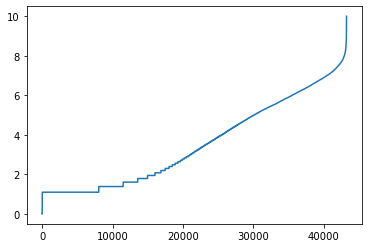

In [154]:
# np.expm1(1)
# plt.plot(np.sort_values(y_log))
# plt.plot((np.log1p(df_train['sellin']+1)).sort_values().values)

In [259]:
# df_train['preds'] = oof
df_train['preds_log'] = np.expm1(oof_log) + min_sellin
# df_train['preds'] = oof
# models[5].predict(X, num_iteration=model.best_iteration)
# df_train ['errors'] = (df_train['preds'] - df_train['sellin'])

# df_train ['errors_log'] = (df_train['preds_log'] - df_train['sellin'])
# abs(df_train[df_train.sku_name.isin(df_test.sku_name.unique())]['errors']).mean()*1013
rmspe(df_train[df_train.sku_name.isin(df_test.sku_name.unique())]['sellin'],
     df_train[df_train.sku_name.isin(df_test.sku_name.unique())]['preds_log'])

261428.19986777686

In [268]:
# df_train['preds_log']
oof_log.max()

8.957380037547232

In [ ]:
W = np.linspace(0,1,100)
l = []
for w in W:
    l.append(rmspe(df_train[df_train.sku_name.isin(df_test.sku_name.unique())]['sellin'],
     (1-w)*df_train[df_train.sku_name.isin(df_test.sku_name.unique())]['preds_log']+w*df_train[df_train.sku_name.isin(df_test.sku_name.unique())]['preds']))

In [ ]:
plt.plot(W,l)
# df_train[df_train.abs_err>500][X.columns.tolist()+['preds','preds_log','errors','sellin']].describe()

In [ ]:
df_train_sort = df_train.sort_values(by = 'abs_err',ascending = False)

In [ ]:
df_train

In [ ]:
# plt.plot(df_train_sort.sellin.values)
# plt.plot(df_train_sort['errors'].values)
# i = 
i=i+1
print(df_train.columns[i])

(df_train[df_train.abs_err>2000][df_train.columns[i]].nunique()/df_train[df_train.columns[i]].nunique()
)/(df_train[df_train.abs_err>2000]['sku_name'].nunique()/df_train['sku_name'].nunique())

In [ ]:
s = (df_train[df_train.abs_err>6000].sku_name).unique()[0]
# for s in sk:
x = df_train.loc[df_train.sku_name == s,'date'].values
y1 = df_train.loc[df_train.sku_name == s,'sellin'].values
y2 = df_train.loc[df_train.sku_name == s,'preds'].values
plt.plot(x,y1,c = 'black')
plt.plot(x,y2)

In [ ]:
# sk
# df_train.corr()['errors_log'].sort_values(ascending = False,key = abs)
df_train['final_pc'] = df_train['sku_name'].map(df_train.groupby('sku_name').apply(lambda x :x['cum_pc'].values[-1]))

In [ ]:
df_train[df_train.abs_err>3000].price.unique()

In [ ]:
# plt.scatter(df_train.date,df_train.cum_pc)
df_train[(df_train.abs_err>3000)& (df_train.date>0)].corr()['sellin'].sort_values(ascending = False,key = abs)

In [ ]:

pd.set_option('display.max_rows', 500)

In [ ]:
# 'FLAG100','date','size','sellin_old'
df_train['pc'] = df_train.groupby('sku_name')['sellin'].pct_change().fillna(0)
df_train['cum_pc'] = df_train.groupby('sku_name').apply(lambda x : (x['pc']+1).cumprod()).values

In [ ]:
# df_train.corr()['errors'].sort_values(ascending = False,key = abs)
df_train['abs_err'] = abs(df_train['errors'])

In [ ]:
df_train

In [ ]:
train.columns

In [ ]:
g = 'sellin'
plt.scatter(x = df_train[mask1].groupby(g)['abs_err'].mean().index, y = df_train[mask1].groupby(g)['abs_err'].mean().values )

In [ ]:
# plt.plot(df_train.groupby('date')['abs_err'].mean())
# df_train[df_train.date==5][['abs_err']].mean()
i =2
mask1 = df_train.sku_name.isin(df_test.sku_name.unique())
(df_train[mask1].groupby(df_train.columns[i])['abs_err'].mean().sort_values(ascending = False)>100).mean()

# df_train.loc[df_train.month ==12].corr()['abs_err'].sort_values(ascending = False,key = abs)

In [ ]:
# df_train.columns[2]
# df_train['FLAG100'].unique().shape
medians = df_train.groupby(['sku_name'])['sellin'].median()

In [ ]:
train_df = df_train.merge(medians,on = ['sku_name'],suffixes = (None,'_med'))

In [ ]:
# mask1
# df_train[mask1]
# train_df['sellin_old2']
train_df['sellin_old2'] = train_df.groupby('sku_name')['sellin'].shift(2).fillna(0)

In [ ]:
train_df.corr()['abs_err']['sellin_old2']

In [ ]:
df_train ['errors'] = (df_train['preds'] - df_train['sellin'])

In [ ]:
a = df_train.groupby('sku_name')['errors'].apply(lambda x : abs(x).mean()).reset_index()
a[a.sku_name.isin(df_test.sku_name.unique())]['errors'].mean()*1013
# .sort_values(by = 'errors',key = abs,ascending =False )

In [ ]:
abs(df_train[df_train.sku_name.isin(df_test.sku_name.unique())]['errors']).mean()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor().fit(df_train[cols], y)
predicted_values = knn_model.predict(df_test[cols])

In [ ]:
# ##### plt.scatter(df_train.loc[df_train.year==2021,'sellin_old'],
# #             df_train.loc[df_train.year==2021,'sellin'],
# #             c = df_train.loc[df_train.year==2021,'cum_disc'])
# # df_train.loc[df_train.year ==2021,'month'].max()
# # plt.plot(df_train.groupby('year')['sellin'].sum()/(df_train.groupby('year')['month'].max()))
# # plt.plot(df_train.groupby('date')['sellin'].sum())
# i = 45
# ids = df_train.loc[df_train.date == i,'sku_name'].values 

# df_train.loc[(df_train.sku_name.isin(ids)) & (df_train.date == i),'sellin'] = df_train[(df_train.sku_name.isin(ids)) ].groupby('sku_name')['sellin'].median().values 

In [ ]:
predicted_values*1013

In [ ]:
from sklearn.model_selection import train_test_split
# X_train_1, X_test_local, y_train_1, y_test_local = train_test_split(X, y, test_size=0.1,shuffle =True, random_state=42)


In [ ]:

# y_train_1.reset_index(drop = True,inplace = True)
# X_train_1.reset_index(drop = True,inplace = True)
# X_train_1

In [ ]:
                         # models
# gkf


In [ ]:
# %%time
# for fold, (trn_idx, val_idx) in enumerate(kf.split(y, groups=X['date'].values)):


In [ ]:
y.isna().sum()

In [ ]:
def eval_model(models,X_test_local,y_test_local,X_train_1):
    target = np.zeros(len(X_test_local))
    # target2 = np.zeros(len(X_test))
    #light gbm models
    for model in models:
        pred = model.predict(X_test_local[X_train_1.columns], num_iteration=model.best_iteration)
        target += pred / len(models)
    
    return rmspe(y_test_local, target)


In [ ]:
X_train_1.columns.shape

In [ ]:
# display_importances(features_importance)
print('local test prediction is : ' + str(eval_model(models,X_test_local,y_test_local,X_train_1)))
print('oof score is :' +str(rmspe(y_train_1, oof)))

In [ ]:
# display_importances(features_importance)
print('local test prediction is : ' + str(eval_model(models,X_test_local,y_test_local,X_train_1,SC)))
print('oof score is :' +str(rmspe(y_train_1, oof,SC)))

In [ ]:
.period_old.unique()

In [ ]:
display_importances(features_importance)
# print('local test prediction is : ' + str(eval_model(models,X_test_local,y_test_local,X_train_1)))
# print('oof score is :' +str(rmspe(y_train_1, oof)))

In [ ]:
'maybe add weeks'

In [ ]:
# eval_model(models,X_test_local,y_test_local,X_train_1)
rmspe(y,oof)


In [262]:
X_test = df_test[X.columns.tolist()].copy()
# X_train
# len(models)

In [263]:
df_test['Item_ID'] = df_test['sku_name'] +'_'+ df_test['month'].astype(str)+ '_'+df_test['year'].astype(str)
y_pred = df_test[['Item_ID']]
target = np.zeros(len(X_test))
target2 = np.zeros(len(X_test))
#light gbm models
for model in models_log:
    pred = model.predict(X_test[X.columns], num_iteration=model.best_iteration)
    pred = np.expm1(pred)+min_sellin
    target += pred / len(models)
# X_test['cum_disc'] = 0
# for model in models:
#     pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
#     target2 += pred / len(models)
# target = (target+target2)/2
y_pred = y_pred.assign(target_y= target)
sub = ss.merge(y_pred,on = 'Item_ID')
sub['target'] = (sub['target_y'])*1013
sub['target'] = (sub['target'].astype('int') )
sub = sub[['Item_ID','target']]

C:\Users\amakr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [270]:
models_log

In [265]:
model.predict(X_test[X.columns], num_iteration=model.best_iteration)

array([4.98073133, 4.28275561, 2.98466074, ..., 2.46379435, 2.3960153 ,
       2.23091279])

In [ ]:
sub.to_csv('goofy.csv',index = False)

In [ ]:
# [s for s in df_test.sku_name.unique() if s not in df_train.sku_name.unique()]
# sub.loc[sub.Item_ID.isin(df_test.loc[df_test.sku_name == 'CATHHALREYZZ','Item_ID'].values),'target'] = 0
# sub
df_test['sellin'] = target

In [ ]:
new_df = pd.concat([df_train,df_test])

In [ ]:
i = 4
a =new_df[new_df.sku_name.isin(df_test.sku_name.unique())].groupby('sku_name').get_group(df_test.sku_name.unique()[i])
x= a['date'].values
y = a['sellin'].values
plt.plot(x[:-4],y[:-4])
plt.plot(x[-5:],y[-5:])


In [ ]:
x[:-4]

In [ ]:
sub.to_csv('submission_aero.csv',index = False)

In [ ]:
import xgboost as xgb
params = {'objective': 'reg:squarederror', 
          'eta': 0.01, 
#               'max_depth': 6, 
#               'subsample': 0.7, 
#               'colsample_bytree': 0.8,  
          'eval_metric': 'rmse', 
          'seed': 42, 
#           'silent': True,
}
verbose = 100
models_xgb =[]
oof_xgb = np.zeros(len(X))
# models = [] 
scores_xgb = 0.0   

features_importance_xgb= pd.DataFrame({'Feature':[], 'Importance':[]})


In [ ]:
%%time

# for fold, (trn_idx, val_idx) in enumerate(kf.split(y, groups=X['date'].values)):
for fold, (trn_idx, val_idx) in enumerate(kf.split(X_log, y_log)):
    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
#     weights = 1/(w_train)
    model = xgb.train(params
                  , xgb.DMatrix(X_train, y_train)
                  , 10000
                  , [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_valid, y_valid), 'valid')]
                  , verbose_eval=verbose
                  , early_stopping_rounds=30
                 )
    # validation
    y_pred = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
#     test_pred = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
#     y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    features = X_train.columns
    oof[val_idx] = y_pred
    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')
    fold_importance_df_xgb= pd.DataFrame({'Feature':[], 'Importance':[]})
    fold_importance_df_xgb['Feature']= features
    fold_importance_df_xgb['Importance']= fold_importance_df_xgb['Feature'].map(model.get_score(importance_type = 'gain')).fillna(0)
    fold_importance_df_xgb["fold"] = fold + 1
    features_importance_xgb = pd.concat([features_importance_xgb, fold_importance_df_xgb], axis=0)
    #keep scores and models
    scores_xgb += RMSPE / kfolds
    models_xgb.append(model)
    print("*" * 100)

In [ ]:
# np.array(list(model.get_score(importance_type='gain').values())).shape
# fold_importance_df_xgb
# len(model.feature_names)
df_test['Item_ID'] = df_test['sku_name'] +'_'+ df_test['month'].astype(str)+ '_'+df_test['year'].astype(str)
y_pred = df_test[['Item_ID']]
target = np.zeros(len(X_test))
target2 = np.zeros(len(X_test))
#light gbm models
for model in models_xgb:
    pred = model.predict(xgb.DMatrix(X_test[X_valid.columns]), ntree_limit=model.best_ntree_limit)
    target += pred / len(models_xgb)
# X_test['cum_disc'] = 0
# for model in models:
#     pred = model.predict(, num_iteration=model.best_iteration)
#     target2 += pred / len(models)
# target = (target+target2)/2
y_pred = y_pred.assign(target_y= target)
sub_xgb = ss.merge(y_pred,on = 'Item_ID')
sub_xgb['target'] = (sub_xgb['target_y'])*1013
sub_xgb['target'] = (sub_xgb['target'].astype('int') )
sub_xgb = sub_xgb[['Item_ID','target']]

In [ ]:
sub_xgb.to_csv('xgb_sub.csv',index = False)

In [ ]:
# sub_blend = sub[['Item_ID']]
# sub_blend['target'] = ((sub_xgb['target']*rmspe(y,oof_xgb))+(sub['target']*rmspe(y,oof)))/(rmspe(y,oof)+rmspe(y,oof_xgb))

In [ ]:
sub_xgb

In [ ]:
sub_blend.to_csv('sub_blend.csv',index = False)

In [ ]:
# models[5].predict(X_test[X_valid.columns], num_iteration=model.best_iteration)*1013
# sns.distplot(df_train.sellin)
# sns.distplot(sub.target
# df_test.drop('item_ID',axis = 1).columns
# df_test.drop('Item_ID',axis = 1).columns


In [ ]:
new_df = pd.concat([df_test.assign(sellin= sub.target/1013).drop('Item_ID',axis = 1),df_train[df_test.drop('Item_ID',axis = 1).columns.tolist()+['sellin']]])

In [ ]:
ids = test.sku_name.unique().tolist()


In [ ]:
i = 0
x1 = new_df.groupby('sku_name').get_group(ids[i])[['month','year','sellin_old']].sort_values(by = ['year','month'])['sellin_old'].values
x2 = new_df.groupby('sku_name').get_group(ids[i])[['month','year','sellin_old']].sort_values(by = ['year','month'])['sellin_old'].values[-5:]
plt.plot(x1)
plt.plot(range(x1.shape[0]-5,x1.shape[0]),x2)
plt.axhline(y = np.median(x1[:-4]), color = 'r', linestyle = '-')
plt.axhline(y = np.mean(x1[:-4]), color = 'g', linestyle = '-')

In [ ]:
x2

In [ ]:
# x1[:-4]
new_df.groupby(['sku_name','year','month']).size().max()

In [ ]:
# str(df_train['year']) +'-'+str(df_train['month'])
# df_train[['year']]
# df_train['date'] = (df_train['year'].astype(str)+ '-'+df_train['month'].astype(str)).apply(lambda _: pd.to_datetime(_,format='%Y-%m', errors='coerce'))
# df_train
df_train['is_train'] = 1
df_test['is_test'] = 1
years = list(range(2016,2022))
ids = df_train.sku_name.unique().tolist()
months = list(range(1,13))
new_frame = pd.DataFrame({'sku_name':np.repeat(ids,len(years)*len(months)),
                         'month':months*len(ids)*len(years),
                         'year':np.repeat(years,len(months)).tolist()*len(ids),
                         'time_step': list(range(len(years)*len(months)))*len(ids)})
new_frame = new_frame.sort_values(by = ['sku_name','year','month']).reset_index(drop =True).merge(df_train[['sku_name','year','month','sellin','is_train']],how = 'left', on = ['sku_name','year','month'])
new_frame['date'] = (new_frame['year'].astype(str)+ '-'+new_frame['month'].astype(str)).apply(lambda _: pd.to_datetime(_,format='%Y-%m', errors='coerce'))
df_test['time_step'] = [70,71,72,73]*int(df_test.shape[0]/4)
new_frame = pd.concat([new_frame.loc[new_frame.date<'2021-11'],df_test])
#
#.apply(lambda _: pd.to_datetime(_,format='%Y-%m', errors='coerce'))

In [ ]:
new_frame.shape

In [ ]:
# new_frame.loc[(new_frame.year == 2021)&(new_frame.month == 1),'Item_ID'].isna().any()
# new_frame

In [ ]:
new_frame['date'] = (new_frame['year'].astype(str)+ '-'+new_frame['month'].astype(str)).apply(lambda _: pd.to_datetime(_,format='%Y-%m', errors='coerce'))

In [ ]:
new_frame.index = new_frame['date']
# a = new_frame[['sku_name','sellin']].gro/upby('sku_name').apply(lambda x: x.interpolate(method = 'time'))
# new_frame['2021-11':'2022-2'] =[60]

In [ ]:
s.sellin.notnull()

In [ ]:
# s
# s.loc[s.sellin.isna(),'time_step'].values
s = new_frame.groupby('sku_name').get_group(ids[1])[['sellin','time_step']]
x = s.loc[s.sellin.notnull(),'time_step'].values-1
xp = s.loc[s.sellin.notnull(),'time_step'].values
fp =  s.loc[s.sellin.notnull(),'sellin'].values

vals = np.array([n for n in x if n not in xp]+[70,71,72,73])
vals = vals[vals>=0]
np.interp(vals,xp,fp).shape[0] - s.loc[s.time_step.isin(vals),'sellin'].shape[0]


In [ ]:
# np.interp(vals,xp,fp)
# s.loc[s.time_step.isin(vals),'sellin']
# s.loc[s.time_step.isin(vals)]
new_frame2.shape[0] - df_train.shape[0]

In [ ]:
# np.interp(x,xp,fp)


In [ ]:
def interpol2(s,is_test = True):
    x = s.loc[s.sellin.notnull(),'time_step'].values-1
    xp = s.loc[s.sellin.notnull(),'time_step'].values
    fp =  s.loc[s.sellin.notnull(),'sellin'].values
    if is_test:
        vals = np.array([n for n in x if n not in xp]+[70,71,72,73])
    else:
        vals = np.array([n for n in x if n not in xp])
    vals = vals[vals>=0]
    if fp.shape[0]<2:
        s.loc[s.time_step.isin(vals),'sellin'] = 0
    else:
        s.loc[s.time_step.isin(vals),'sellin'] = np.interp(vals,xp,fp)
    return s 

In [ ]:
new_ids = [i for i in train.sku_name.unique() if i not in test.sku_name.unique()]

In [ ]:
# a = new_frame[new_frame.sku_name.isin(df_test.sku_name.unique())].groupby('sku_name')[['time_step','sellin']].apply(lambda x : interpol2(x))

In [ ]:
a = new_frame[new_frame.sku_name.isin(df_test.sku_name.unique())].reset_index(drop = True).groupby('sku_name',as_index = True)[['time_step','sellin','sku_name']].apply(lambda x : interpol2(x))
b = new_frame[new_frame.sku_name.isin(new_ids)].reset_index(drop = True).groupby('sku_name',as_index = True)[['time_step','sellin','sku_name']].apply(lambda x : interpol2(x,is_test = False))

In [ ]:
a = a.groupby('sku_name',as_index = True).apply(lambda x :x.shift(1)).fillna(-1)
a['time_step'] = a['time_step']+1 
b= b.groupby('sku_name',as_index = True).apply(lambda x :x.shift(1)).fillna(-1)
b['time_step'] = b['time_step']+1 
new_frame2 = new_frame.merge(a, on= ['sku_name','time_step'],how = 'left',suffixes = (None,'_old') ).merge(a, on= ['sku_name','time_step'],suffixes = (None,'_old'))

In [ ]:
new_frame2.loc[(new_frame2.is_train == 1)&(new_frame2.sku_name.notnull())]
# df_train.shape
# new_frame2.columns

In [ ]:
a.groupby('sku_name').get_group(test.sku_name.unique()[0])[['sellin']].shift(1)

In [ ]:
plt.plot(a.groupby('sku_name').get_group(ids[0])['sellin'])

In [ ]:
sub.to_csv('submission_42_neg4.csv',index = False)

In [ ]:
# len(models)
ss['sku_month'] = ss['Item_ID'].apply(lambda x: x.split('_')[0])+'_'+ss['Item_ID'].apply(lambda x: x.split('_')[1])

In [ ]:
df_train['sku_month'] = df_train['sku_name']+'_'+df_train['month'].astype(str)

In [ ]:
# ss.loc[ss.sku_month.isin(df_train.sku_month)]
plt.plot(np.log(df_train['sellin'].sort_values().values[3:-301]))

In [ ]:
ss.shape[0]

In [ ]:
# df_test.apply(lambda x: '_'.join(x['sku_name'],x['month']))


# Clusters

In [ ]:

cluster_range = range(1,15)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(df_train[sellin+sellout+onhand+['month','year']])
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
# clusters_df
from matplotlib import cm

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [ ]:
# np.unique(labels)

In [ ]:
!pip install flaml

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
from flaml import AutoML
automl = AutoML()

In [ ]:
automl.fit(X_train, y_train, task="regression",metric='mae',time_budget=898)

In [ ]:
print('Best ML learner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best mae on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

In [ ]:
df_test['Item_ID'] = df_test['sku_name'] +'_'+ df_test['month'].astype(str)+ '_'+df_test['year'].astype(str)
y_pred = df_test[['Item_ID']]
target = np.zeros(len(X_test))

#light gbm models

pred = automl.predict(df_test[X_train.columns])
target = pred 
y_pred = y_pred.assign(target_y= target)
sub = ss.merge(y_pred,on = 'Item_ID')
sub['target'] = sub['target_y']*1013
sub['target'] = sub['target'].astype('int') 
sub = sub[['Item_ID','target']]

In [ ]:
sub.to_csv('submission_21.csv',index = False)